In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import spacy
import re
import contractions
import unicodedata
import nltk
import string

# Load nltk stopwords
from nltk.corpus import stopwords

In [3]:
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import warnings

# FinBERT

In [ ]:
#!pip install -q scikit-learn datasets torch transformers evaluate optuna

In [ ]:
#!pip install "numpy<2.0.0"

In [5]:
# Step 1: Import Libraries

import torch
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import evaluate


# Step 2: Load the dataset
df = pd.read_csv("Dataset/Cleaned Sentence Data/Cleaned Annual Reports.csv")  # Replace with your dataset path
assert 'Sentence' in df.columns and 'Sentiment' in df.columns, "CSV must have 'Sentence' and 'Sentiment' columns"

# Step 3: Encode labels if needed
if df['Sentiment'].dtype == object:
    le = LabelEncoder()
    df['Sentiment'] = le.fit_transform(df['Sentiment'])  # Save le.classes_ if needed for decoding

# Step 4: Convert to Hugging Face Dataset and split
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.3, seed=42)
temp = dataset["test"].train_test_split(test_size=0.5, seed=42)

dataset = DatasetDict({
    'train': dataset['train'],
    'validation': temp['train'],
    'test': temp['test']
})

train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

# Step 5: Tokenization
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['Sentence'], truncation=True, padding='max_length', max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Remove non-numeric columns
for d in [train_dataset, val_dataset, test_dataset]:
    if '__index_level_0__' in d.column_names:
        d = d.remove_columns(['Sentence', '__index_level_0__'])
    else:
        d = d.remove_columns(['Sentence'])


train_dataset = train_dataset.rename_column("Sentiment", "labels")
val_dataset = val_dataset.rename_column("Sentiment", "labels")
test_dataset = test_dataset.rename_column("Sentiment", "labels")

train_dataset = train_dataset.with_format("torch", columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
val_dataset = val_dataset.with_format("torch", columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.with_format("torch", columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


# Step 6: Load FinBERT model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(df['Sentiment'].unique())
)


# Load F1 metric (can also add accuracy if desired)
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(df['Sentiment'].unique())
    )

def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10),
    }

# Step 7: Define training arguments
training_args = TrainingArguments(
    output_dir="Natural Language Processing/Models/optimized_finbert_sentiment",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

# Step 8: Initialize Trainer with early stopping
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # stops after 5 epochs with no improvement
)

best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=10,  # increase for more thorough search
    hp_space=hp_space,
    compute_objective=lambda metrics: metrics["eval_f1"]
)

best_args = training_args

# Update args with best values
best_args.learning_rate = best_run.hyperparameters["learning_rate"]
best_args.per_device_train_batch_size = best_run.hyperparameters["per_device_train_batch_size"]
best_args.weight_decay = best_run.hyperparameters["weight_decay"]
best_args.num_train_epochs = best_run.hyperparameters["num_train_epochs"]

# Recreate Trainer with best config
trainer = Trainer(
    model_init=model_init,
    args=best_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# Step 9: Train
trainer.train()

# Step 10: Save the best model
#trainer.save_model("Natural Language Processing/Models/final_finbert_model")
history = trainer.state.log_history
history_df = pd.DataFrame(history)
#history_df.to_csv("Natural Language Processing/Models/training_history.csv", index=False)

#tokenizer.save_pretrained("Natural Language Processing/Models/final_finbert_model")

# Step 11: Evaluate
preds_output = trainer.predict(test_dataset)
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

report = classification_report(true_labels, pred_labels, target_names=le.classes_, digits=4)
print(report)

/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0606 12:30:30.550000 15535 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 709/709 [00:00<00:00, 25339.66 examples/s]
[I 2025-06-06 12:30:35,068] A new study created in memory with name: no-name-e39d3e1e-6156-4242-bc45-935c243f1c4f
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411:

{'loss': 4.1725, 'learning_rate': 1.689688221809387e-05, 'epoch': 0.1}


  3%|▎         | 20/624 [00:18<07:16,  1.38it/s]

{'loss': 1.2357, 'learning_rate': 1.662168869662654e-05, 'epoch': 0.19}


  5%|▍         | 30/624 [00:26<07:09,  1.38it/s]

{'loss': 0.761, 'learning_rate': 1.6346495175159213e-05, 'epoch': 0.29}


  6%|▋         | 40/624 [00:33<06:58,  1.39it/s]

{'loss': 0.7492, 'learning_rate': 1.607130165369189e-05, 'epoch': 0.38}


  8%|▊         | 50/624 [00:40<06:55,  1.38it/s]

{'loss': 0.5602, 'learning_rate': 1.579610813222456e-05, 'epoch': 0.48}


 10%|▉         | 60/624 [00:47<06:48,  1.38it/s]

{'loss': 0.6852, 'learning_rate': 1.5520914610757234e-05, 'epoch': 0.58}


 11%|█         | 70/624 [00:54<06:39,  1.39it/s]

{'loss': 0.5899, 'learning_rate': 1.5245721089289908e-05, 'epoch': 0.67}


 13%|█▎        | 80/624 [01:02<06:34,  1.38it/s]

{'loss': 0.5121, 'learning_rate': 1.4970527567822582e-05, 'epoch': 0.77}


 14%|█▍        | 90/624 [01:09<06:30,  1.37it/s]

{'loss': 0.5282, 'learning_rate': 1.4695334046355253e-05, 'epoch': 0.87}


 16%|█▌        | 100/624 [01:16<06:20,  1.38it/s]

{'loss': 0.5431, 'learning_rate': 1.4420140524887927e-05, 'epoch': 0.96}


                                                 
 17%|█▋        | 104/624 [01:25<07:41,  1.13it/s]

{'eval_loss': 0.48809224367141724, 'eval_accuracy': 0.8375706214689266, 'eval_f1': 0.8143235591574979, 'eval_runtime': 5.4574, 'eval_samples_per_second': 129.731, 'eval_steps_per_second': 8.246, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 18%|█▊        | 110/624 [01:33<10:17,  1.20s/it]

{'loss': 0.3528, 'learning_rate': 1.41449470034206e-05, 'epoch': 1.06}


 19%|█▉        | 120/624 [01:40<06:11,  1.36it/s]

{'loss': 0.2982, 'learning_rate': 1.3869753481953274e-05, 'epoch': 1.15}


 21%|██        | 130/624 [01:48<05:58,  1.38it/s]

{'loss': 0.3025, 'learning_rate': 1.3594559960485946e-05, 'epoch': 1.25}


 22%|██▏       | 140/624 [01:55<05:47,  1.39it/s]

{'loss': 0.2545, 'learning_rate': 1.331936643901862e-05, 'epoch': 1.35}


 24%|██▍       | 150/624 [02:02<05:39,  1.40it/s]

{'loss': 0.2259, 'learning_rate': 1.3044172917551293e-05, 'epoch': 1.44}


 26%|██▌       | 160/624 [02:09<05:28,  1.41it/s]

{'loss': 0.2676, 'learning_rate': 1.2768979396083967e-05, 'epoch': 1.54}


 27%|██▋       | 170/624 [02:16<05:21,  1.41it/s]

{'loss': 0.1911, 'learning_rate': 1.2493785874616639e-05, 'epoch': 1.63}


 29%|██▉       | 180/624 [02:23<05:19,  1.39it/s]

{'loss': 0.2662, 'learning_rate': 1.2218592353149313e-05, 'epoch': 1.73}


 30%|███       | 190/624 [02:31<05:13,  1.39it/s]

{'loss': 0.2352, 'learning_rate': 1.1943398831681986e-05, 'epoch': 1.83}


 32%|███▏      | 200/624 [02:38<05:02,  1.40it/s]

{'loss': 0.2261, 'learning_rate': 1.166820531021466e-05, 'epoch': 1.92}


                                                 
 33%|███▎      | 208/624 [02:48<04:02,  1.72it/s]

{'eval_loss': 0.26014015078544617, 'eval_accuracy': 0.9180790960451978, 'eval_f1': 0.9126584211329973, 'eval_runtime': 5.1178, 'eval_samples_per_second': 138.339, 'eval_steps_per_second': 8.793, 'epoch': 2.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 34%|███▎      | 210/624 [02:52<15:32,  2.25s/it]

{'loss': 0.1246, 'learning_rate': 1.1393011788747332e-05, 'epoch': 2.02}


 35%|███▌      | 220/624 [02:59<05:10,  1.30it/s]

{'loss': 0.0928, 'learning_rate': 1.1117818267280006e-05, 'epoch': 2.12}


 37%|███▋      | 230/624 [03:07<04:44,  1.38it/s]

{'loss': 0.0773, 'learning_rate': 1.0842624745812679e-05, 'epoch': 2.21}


 38%|███▊      | 240/624 [03:14<04:37,  1.39it/s]

{'loss': 0.1136, 'learning_rate': 1.0567431224345353e-05, 'epoch': 2.31}


 40%|████      | 250/624 [03:21<04:29,  1.39it/s]

{'loss': 0.0714, 'learning_rate': 1.0292237702878025e-05, 'epoch': 2.4}


 42%|████▏     | 260/624 [03:28<04:22,  1.39it/s]

{'loss': 0.085, 'learning_rate': 1.00170441814107e-05, 'epoch': 2.5}


 43%|████▎     | 270/624 [03:35<04:15,  1.39it/s]

{'loss': 0.0968, 'learning_rate': 9.74185065994337e-06, 'epoch': 2.6}


 45%|████▍     | 280/624 [03:42<04:05,  1.40it/s]

{'loss': 0.0657, 'learning_rate': 9.466657138476044e-06, 'epoch': 2.69}


 46%|████▋     | 290/624 [03:50<04:00,  1.39it/s]

{'loss': 0.0989, 'learning_rate': 9.191463617008716e-06, 'epoch': 2.79}


 48%|████▊     | 300/624 [03:57<03:55,  1.38it/s]

{'loss': 0.0684, 'learning_rate': 8.91627009554139e-06, 'epoch': 2.88}


 50%|████▉     | 310/624 [04:04<03:46,  1.38it/s]

{'loss': 0.0683, 'learning_rate': 8.641076574074063e-06, 'epoch': 2.98}


                                                 
 50%|█████     | 312/624 [04:10<02:59,  1.74it/s]

{'eval_loss': 0.17304223775863647, 'eval_accuracy': 0.9477401129943502, 'eval_f1': 0.9466638374421461, 'eval_runtime': 5.164, 'eval_samples_per_second': 137.103, 'eval_steps_per_second': 8.714, 'epoch': 3.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 51%|█████▏    | 320/624 [04:19<04:38,  1.09it/s]

{'loss': 0.012, 'learning_rate': 8.365883052606737e-06, 'epoch': 3.08}


 53%|█████▎    | 330/624 [04:26<03:33,  1.38it/s]

{'loss': 0.0259, 'learning_rate': 8.09068953113941e-06, 'epoch': 3.17}


 54%|█████▍    | 340/624 [04:33<03:29,  1.36it/s]

{'loss': 0.0099, 'learning_rate': 7.815496009672084e-06, 'epoch': 3.27}


 56%|█████▌    | 350/624 [04:41<03:22,  1.35it/s]

{'loss': 0.0563, 'learning_rate': 7.540302488204756e-06, 'epoch': 3.37}


 58%|█████▊    | 360/624 [04:48<03:11,  1.38it/s]

{'loss': 0.0268, 'learning_rate': 7.265108966737429e-06, 'epoch': 3.46}


 59%|█████▉    | 370/624 [04:55<03:02,  1.39it/s]

{'loss': 0.0182, 'learning_rate': 6.9899154452701025e-06, 'epoch': 3.56}


 61%|██████    | 380/624 [05:03<02:55,  1.39it/s]

{'loss': 0.0207, 'learning_rate': 6.714721923802776e-06, 'epoch': 3.65}


 62%|██████▎   | 390/624 [05:10<02:48,  1.39it/s]

{'loss': 0.0308, 'learning_rate': 6.439528402335449e-06, 'epoch': 3.75}


 64%|██████▍   | 400/624 [05:17<02:40,  1.40it/s]

{'loss': 0.0086, 'learning_rate': 6.1643348808681214e-06, 'epoch': 3.85}


 66%|██████▌   | 410/624 [05:24<02:33,  1.39it/s]

{'loss': 0.0165, 'learning_rate': 5.889141359400795e-06, 'epoch': 3.94}


                                                 
 67%|██████▋   | 416/624 [05:33<01:58,  1.75it/s]

{'eval_loss': 0.17115256190299988, 'eval_accuracy': 0.961864406779661, 'eval_f1': 0.9603522986924715, 'eval_runtime': 5.1092, 'eval_samples_per_second': 138.574, 'eval_steps_per_second': 8.808, 'epoch': 4.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 67%|██████▋   | 420/624 [05:38<05:02,  1.48s/it]

{'loss': 0.0062, 'learning_rate': 5.613947837933468e-06, 'epoch': 4.04}


 69%|██████▉   | 430/624 [05:46<02:23,  1.35it/s]

{'loss': 0.0019, 'learning_rate': 5.338754316466141e-06, 'epoch': 4.13}


 71%|███████   | 440/624 [05:53<02:12,  1.39it/s]

{'loss': 0.0017, 'learning_rate': 5.0635607949988145e-06, 'epoch': 4.23}


 72%|███████▏  | 450/624 [06:00<02:06,  1.37it/s]

{'loss': 0.0026, 'learning_rate': 4.788367273531488e-06, 'epoch': 4.33}


 74%|███████▎  | 460/624 [06:07<02:02,  1.34it/s]

{'loss': 0.0029, 'learning_rate': 4.513173752064161e-06, 'epoch': 4.42}


 75%|███████▌  | 470/624 [06:15<01:51,  1.38it/s]

{'loss': 0.0007, 'learning_rate': 4.237980230596834e-06, 'epoch': 4.52}


 77%|███████▋  | 480/624 [06:22<01:43,  1.39it/s]

{'loss': 0.0075, 'learning_rate': 3.962786709129507e-06, 'epoch': 4.62}


 79%|███████▊  | 490/624 [06:29<01:36,  1.39it/s]

{'loss': 0.0082, 'learning_rate': 3.68759318766218e-06, 'epoch': 4.71}


 80%|████████  | 500/624 [06:36<01:29,  1.39it/s]

{'loss': 0.001, 'learning_rate': 3.4123996661948527e-06, 'epoch': 4.81}


 82%|████████▏ | 510/624 [06:43<01:22,  1.39it/s]

{'loss': 0.014, 'learning_rate': 3.137206144727526e-06, 'epoch': 4.9}


 83%|████████▎ | 520/624 [06:50<01:00,  1.71it/s]

{'loss': 0.0014, 'learning_rate': 2.8620126232601992e-06, 'epoch': 5.0}


                                                 
 83%|████████▎ | 520/624 [06:55<01:00,  1.71it/s]

{'eval_loss': 0.18071962893009186, 'eval_accuracy': 0.9646892655367232, 'eval_f1': 0.9631502618581039, 'eval_runtime': 5.1308, 'eval_samples_per_second': 137.99, 'eval_steps_per_second': 8.771, 'epoch': 5.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 85%|████████▍ | 530/624 [07:05<01:16,  1.23it/s]

{'loss': 0.0006, 'learning_rate': 2.5868191017928725e-06, 'epoch': 5.1}


 87%|████████▋ | 540/624 [07:12<01:01,  1.37it/s]

{'loss': 0.0004, 'learning_rate': 2.3116255803255457e-06, 'epoch': 5.19}


 88%|████████▊ | 550/624 [07:20<00:53,  1.39it/s]

{'loss': 0.0013, 'learning_rate': 2.0364320588582186e-06, 'epoch': 5.29}


 90%|████████▉ | 560/624 [07:27<00:46,  1.38it/s]

{'loss': 0.0011, 'learning_rate': 1.7612385373908918e-06, 'epoch': 5.38}


 91%|█████████▏| 570/624 [07:34<00:39,  1.38it/s]

{'loss': 0.0017, 'learning_rate': 1.486045015923565e-06, 'epoch': 5.48}


 93%|█████████▎| 580/624 [07:41<00:31,  1.39it/s]

{'loss': 0.0074, 'learning_rate': 1.2108514944562381e-06, 'epoch': 5.58}


 95%|█████████▍| 590/624 [07:48<00:24,  1.40it/s]

{'loss': 0.0005, 'learning_rate': 9.356579729889114e-07, 'epoch': 5.67}


 96%|█████████▌| 600/624 [07:56<00:17,  1.41it/s]

{'loss': 0.0006, 'learning_rate': 6.604644515215845e-07, 'epoch': 5.77}


 98%|█████████▊| 610/624 [08:03<00:10,  1.39it/s]

{'loss': 0.0007, 'learning_rate': 3.852709300542576e-07, 'epoch': 5.87}


 99%|█████████▉| 620/624 [08:10<00:02,  1.39it/s]

{'loss': 0.0003, 'learning_rate': 1.1007740858693074e-07, 'epoch': 5.96}


                                                 
100%|██████████| 624/624 [08:18<00:00,  1.72it/s]

{'eval_loss': 0.17492757737636566, 'eval_accuracy': 0.9661016949152542, 'eval_f1': 0.964770787067522, 'eval_runtime': 5.0998, 'eval_samples_per_second': 138.829, 'eval_steps_per_second': 8.824, 'epoch': 6.0}


100%|██████████| 624/624 [08:20<00:00,  1.25it/s]
[I 2025-06-06 12:38:56,750] Trial 0 finished with value: 0.964770787067522 and parameters: {'learning_rate': 1.7172075739561196e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.02767435580286073, 'num_train_epochs': 6}. Best is trial 0 with value: 0.964770787067522.
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'train_runtime': 500.655, 'train_samples_per_second': 39.608, 'train_steps_per_second': 1.246, 'train_loss': 0.22770850674267143, 'epoch': 6.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1863 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  1%|          | 10/1863 [00:05<12:10,  2.54it/s]

{'loss': 4.1309, 'learning_rate': 2.0478911960040622e-05, 'epoch': 0.05}


  1%|          | 20/1863 [00:09<12:10,  2.52it/s]

{'loss': 1.2786, 'learning_rate': 2.0368394356370678e-05, 'epoch': 0.1}


  2%|▏         | 30/1863 [00:12<11:34,  2.64it/s]

{'loss': 0.7397, 'learning_rate': 2.0257876752700733e-05, 'epoch': 0.14}


  2%|▏         | 40/1863 [00:16<11:41,  2.60it/s]

{'loss': 0.6744, 'learning_rate': 2.014735914903079e-05, 'epoch': 0.19}


  3%|▎         | 50/1863 [00:20<12:10,  2.48it/s]

{'loss': 0.6342, 'learning_rate': 2.0036841545360845e-05, 'epoch': 0.24}


  3%|▎         | 60/1863 [00:24<12:17,  2.45it/s]

{'loss': 0.5341, 'learning_rate': 1.99263239416909e-05, 'epoch': 0.29}


  4%|▍         | 70/1863 [00:28<11:43,  2.55it/s]

{'loss': 0.7515, 'learning_rate': 1.981580633802096e-05, 'epoch': 0.34}


  4%|▍         | 80/1863 [00:32<12:22,  2.40it/s]

{'loss': 0.8305, 'learning_rate': 1.9705288734351016e-05, 'epoch': 0.39}


  5%|▍         | 90/1863 [00:36<11:49,  2.50it/s]

{'loss': 0.5636, 'learning_rate': 1.959477113068107e-05, 'epoch': 0.43}


  5%|▌         | 100/1863 [00:41<12:36,  2.33it/s]

{'loss': 0.446, 'learning_rate': 1.9484253527011127e-05, 'epoch': 0.48}


  6%|▌         | 110/1863 [00:44<11:07,  2.63it/s]

{'loss': 0.5164, 'learning_rate': 1.9373735923341183e-05, 'epoch': 0.53}


  6%|▋         | 120/1863 [00:48<11:11,  2.59it/s]

{'loss': 0.532, 'learning_rate': 1.926321831967124e-05, 'epoch': 0.58}


  7%|▋         | 130/1863 [00:52<10:41,  2.70it/s]

{'loss': 0.2787, 'learning_rate': 1.9152700716001294e-05, 'epoch': 0.63}


  8%|▊         | 140/1863 [00:56<10:53,  2.64it/s]

{'loss': 0.2911, 'learning_rate': 1.904218311233135e-05, 'epoch': 0.68}


  8%|▊         | 150/1863 [01:00<10:59,  2.60it/s]

{'loss': 0.3381, 'learning_rate': 1.8931665508661406e-05, 'epoch': 0.72}


  9%|▊         | 160/1863 [01:04<10:42,  2.65it/s]

{'loss': 0.4757, 'learning_rate': 1.882114790499146e-05, 'epoch': 0.77}


  9%|▉         | 170/1863 [01:07<10:28,  2.69it/s]

{'loss': 0.3897, 'learning_rate': 1.8710630301321517e-05, 'epoch': 0.82}


 10%|▉         | 180/1863 [01:11<10:26,  2.69it/s]

{'loss': 0.4239, 'learning_rate': 1.8600112697651573e-05, 'epoch': 0.87}


 10%|█         | 190/1863 [01:15<10:37,  2.62it/s]

{'loss': 0.323, 'learning_rate': 1.848959509398163e-05, 'epoch': 0.92}


 11%|█         | 200/1863 [01:19<10:47,  2.57it/s]

{'loss': 0.3398, 'learning_rate': 1.8379077490311685e-05, 'epoch': 0.97}


 11%|█         | 207/1863 [01:27<09:40,  2.85it/s]

{'eval_loss': 0.3433900475502014, 'eval_accuracy': 0.905367231638418, 'eval_f1': 0.8952502180683352, 'eval_runtime': 5.2326, 'eval_samples_per_second': 135.306, 'eval_steps_per_second': 8.6, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 11%|█▏        | 210/1863 [01:30<41:49,  1.52s/it]  

{'loss': 0.2226, 'learning_rate': 1.8268559886641744e-05, 'epoch': 1.01}


 12%|█▏        | 220/1863 [01:34<11:32,  2.37it/s]

{'loss': 0.1467, 'learning_rate': 1.81580422829718e-05, 'epoch': 1.06}


 12%|█▏        | 230/1863 [01:38<10:34,  2.58it/s]

{'loss': 0.2073, 'learning_rate': 1.8047524679301855e-05, 'epoch': 1.11}


 13%|█▎        | 240/1863 [01:42<10:30,  2.57it/s]

{'loss': 0.1595, 'learning_rate': 1.793700707563191e-05, 'epoch': 1.16}


 13%|█▎        | 250/1863 [01:46<10:34,  2.54it/s]

{'loss': 0.1846, 'learning_rate': 1.7826489471961967e-05, 'epoch': 1.21}


 14%|█▍        | 260/1863 [01:50<10:21,  2.58it/s]

{'loss': 0.1534, 'learning_rate': 1.7715971868292023e-05, 'epoch': 1.26}


 14%|█▍        | 270/1863 [01:54<10:17,  2.58it/s]

{'loss': 0.1012, 'learning_rate': 1.7605454264622078e-05, 'epoch': 1.3}


 15%|█▌        | 280/1863 [01:58<10:11,  2.59it/s]

{'loss': 0.1773, 'learning_rate': 1.7494936660952134e-05, 'epoch': 1.35}


 16%|█▌        | 290/1863 [02:01<10:09,  2.58it/s]

{'loss': 0.1298, 'learning_rate': 1.738441905728219e-05, 'epoch': 1.4}


 16%|█▌        | 300/1863 [02:05<10:06,  2.58it/s]

{'loss': 0.0892, 'learning_rate': 1.7273901453612246e-05, 'epoch': 1.45}


 17%|█▋        | 310/1863 [02:09<09:59,  2.59it/s]

{'loss': 0.1244, 'learning_rate': 1.7163383849942305e-05, 'epoch': 1.5}


 17%|█▋        | 320/1863 [02:14<12:44,  2.02it/s]

{'loss': 0.0915, 'learning_rate': 1.7052866246272357e-05, 'epoch': 1.55}


 18%|█▊        | 330/1863 [02:18<10:36,  2.41it/s]

{'loss': 0.0838, 'learning_rate': 1.6942348642602413e-05, 'epoch': 1.59}


 18%|█▊        | 340/1863 [02:22<10:09,  2.50it/s]

{'loss': 0.0553, 'learning_rate': 1.683183103893247e-05, 'epoch': 1.64}


 19%|█▉        | 350/1863 [02:26<09:36,  2.63it/s]

{'loss': 0.1618, 'learning_rate': 1.6721313435262528e-05, 'epoch': 1.69}


 19%|█▉        | 360/1863 [02:30<09:30,  2.64it/s]

{'loss': 0.0535, 'learning_rate': 1.6610795831592583e-05, 'epoch': 1.74}


 20%|█▉        | 370/1863 [02:34<10:55,  2.28it/s]

{'loss': 0.0191, 'learning_rate': 1.650027822792264e-05, 'epoch': 1.79}


 20%|██        | 380/1863 [02:38<09:19,  2.65it/s]

{'loss': 0.1522, 'learning_rate': 1.6389760624252695e-05, 'epoch': 1.84}


 21%|██        | 390/1863 [02:42<09:15,  2.65it/s]

{'loss': 0.0213, 'learning_rate': 1.627924302058275e-05, 'epoch': 1.88}


 21%|██▏       | 400/1863 [02:46<10:07,  2.41it/s]

{'loss': 0.0717, 'learning_rate': 1.6168725416912806e-05, 'epoch': 1.93}


 22%|██▏       | 410/1863 [02:50<09:32,  2.54it/s]

{'loss': 0.0139, 'learning_rate': 1.6058207813242862e-05, 'epoch': 1.98}


 22%|██▏       | 414/1863 [02:56<08:23,  2.88it/s]

{'eval_loss': 0.12359210848808289, 'eval_accuracy': 0.9759887005649718, 'eval_f1': 0.9757485367797998, 'eval_runtime': 5.1204, 'eval_samples_per_second': 138.269, 'eval_steps_per_second': 8.788, 'epoch': 2.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 23%|██▎       | 420/1863 [03:01<18:47,  1.28it/s]  

{'loss': 0.0286, 'learning_rate': 1.5947690209572918e-05, 'epoch': 2.03}


 23%|██▎       | 430/1863 [03:05<09:26,  2.53it/s]

{'loss': 0.0008, 'learning_rate': 1.5837172605902974e-05, 'epoch': 2.08}


 24%|██▎       | 440/1863 [03:09<09:04,  2.61it/s]

{'loss': 0.0017, 'learning_rate': 1.572665500223303e-05, 'epoch': 2.13}


 24%|██▍       | 450/1863 [03:13<08:58,  2.62it/s]

{'loss': 0.032, 'learning_rate': 1.561613739856309e-05, 'epoch': 2.17}


 25%|██▍       | 460/1863 [03:17<08:53,  2.63it/s]

{'loss': 0.0018, 'learning_rate': 1.550561979489314e-05, 'epoch': 2.22}


 25%|██▌       | 470/1863 [03:20<08:48,  2.63it/s]

{'loss': 0.038, 'learning_rate': 1.5395102191223197e-05, 'epoch': 2.27}


 26%|██▌       | 480/1863 [03:24<08:40,  2.66it/s]

{'loss': 0.0022, 'learning_rate': 1.5284584587553253e-05, 'epoch': 2.32}


 26%|██▋       | 490/1863 [03:28<09:26,  2.42it/s]

{'loss': 0.0027, 'learning_rate': 1.5174066983883312e-05, 'epoch': 2.37}


 27%|██▋       | 500/1863 [03:32<08:47,  2.58it/s]

{'loss': 0.0014, 'learning_rate': 1.5063549380213367e-05, 'epoch': 2.42}


 27%|██▋       | 510/1863 [03:36<08:33,  2.63it/s]

{'loss': 0.002, 'learning_rate': 1.4953031776543423e-05, 'epoch': 2.46}


 28%|██▊       | 520/1863 [03:40<08:29,  2.63it/s]

{'loss': 0.0001, 'learning_rate': 1.4842514172873477e-05, 'epoch': 2.51}


 28%|██▊       | 530/1863 [03:44<08:23,  2.65it/s]

{'loss': 0.0177, 'learning_rate': 1.4731996569203533e-05, 'epoch': 2.56}


 29%|██▉       | 540/1863 [03:47<08:20,  2.65it/s]

{'loss': 0.0001, 'learning_rate': 1.4621478965533592e-05, 'epoch': 2.61}


 30%|██▉       | 550/1863 [03:51<08:15,  2.65it/s]

{'loss': 0.0127, 'learning_rate': 1.4510961361863646e-05, 'epoch': 2.66}


 30%|███       | 560/1863 [03:55<08:09,  2.66it/s]

{'loss': 0.0034, 'learning_rate': 1.4400443758193702e-05, 'epoch': 2.71}


 31%|███       | 570/1863 [03:59<08:05,  2.66it/s]

{'loss': 0.0034, 'learning_rate': 1.4289926154523758e-05, 'epoch': 2.75}


 31%|███       | 580/1863 [04:03<08:03,  2.65it/s]

{'loss': 0.0048, 'learning_rate': 1.4179408550853813e-05, 'epoch': 2.8}


 32%|███▏      | 590/1863 [04:06<07:58,  2.66it/s]

{'loss': 0.0019, 'learning_rate': 1.4068890947183871e-05, 'epoch': 2.85}


 32%|███▏      | 600/1863 [04:10<07:57,  2.64it/s]

{'loss': 0.0001, 'learning_rate': 1.3958373343513927e-05, 'epoch': 2.9}


 33%|███▎      | 610/1863 [04:14<07:51,  2.66it/s]

{'loss': 0.0004, 'learning_rate': 1.3847855739843982e-05, 'epoch': 2.95}


 33%|███▎      | 620/1863 [04:18<07:53,  2.63it/s]

{'loss': 0.004, 'learning_rate': 1.3737338136174038e-05, 'epoch': 3.0}


 33%|███▎      | 621/1863 [04:23<07:05,  2.92it/s]

{'eval_loss': 0.11628186702728271, 'eval_accuracy': 0.9844632768361582, 'eval_f1': 0.9841985089688668, 'eval_runtime': 5.148, 'eval_samples_per_second': 137.529, 'eval_steps_per_second': 8.741, 'epoch': 3.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 34%|███▍      | 630/1863 [04:29<10:26,  1.97it/s]

{'loss': 0.0, 'learning_rate': 1.3626820532504096e-05, 'epoch': 3.04}


 34%|███▍      | 640/1863 [04:33<07:47,  2.62it/s]

{'loss': 0.0, 'learning_rate': 1.3516302928834151e-05, 'epoch': 3.09}


 35%|███▍      | 650/1863 [04:37<07:38,  2.65it/s]

{'loss': 0.0005, 'learning_rate': 1.3405785325164207e-05, 'epoch': 3.14}


 35%|███▌      | 660/1863 [04:40<07:36,  2.64it/s]

{'loss': 0.0, 'learning_rate': 1.3295267721494263e-05, 'epoch': 3.19}


 36%|███▌      | 670/1863 [04:44<07:31,  2.64it/s]

{'loss': 0.0, 'learning_rate': 1.3184750117824317e-05, 'epoch': 3.24}


 37%|███▋      | 680/1863 [04:48<07:27,  2.65it/s]

{'loss': 0.0, 'learning_rate': 1.3074232514154376e-05, 'epoch': 3.29}


 37%|███▋      | 690/1863 [04:52<07:20,  2.66it/s]

{'loss': 0.0026, 'learning_rate': 1.296371491048443e-05, 'epoch': 3.33}


 38%|███▊      | 700/1863 [04:56<07:35,  2.56it/s]

{'loss': 0.0039, 'learning_rate': 1.2853197306814486e-05, 'epoch': 3.38}


 38%|███▊      | 710/1863 [05:00<07:29,  2.57it/s]

{'loss': 0.0, 'learning_rate': 1.2742679703144542e-05, 'epoch': 3.43}


 39%|███▊      | 720/1863 [05:03<07:20,  2.60it/s]

{'loss': 0.0, 'learning_rate': 1.2632162099474597e-05, 'epoch': 3.48}


 39%|███▉      | 730/1863 [05:07<07:06,  2.66it/s]

{'loss': 0.0, 'learning_rate': 1.2521644495804655e-05, 'epoch': 3.53}


 40%|███▉      | 740/1863 [05:11<07:17,  2.57it/s]

{'loss': 0.0024, 'learning_rate': 1.241112689213471e-05, 'epoch': 3.57}


 40%|████      | 750/1863 [05:15<07:11,  2.58it/s]

{'loss': 0.0, 'learning_rate': 1.2300609288464766e-05, 'epoch': 3.62}


 41%|████      | 760/1863 [05:19<07:02,  2.61it/s]

{'loss': 0.0004, 'learning_rate': 1.2190091684794822e-05, 'epoch': 3.67}


 41%|████▏     | 770/1863 [05:23<07:11,  2.53it/s]

{'loss': 0.0001, 'learning_rate': 1.207957408112488e-05, 'epoch': 3.72}


 42%|████▏     | 780/1863 [05:27<06:54,  2.61it/s]

{'loss': 0.0, 'learning_rate': 1.1969056477454935e-05, 'epoch': 3.77}


 42%|████▏     | 790/1863 [05:31<06:50,  2.61it/s]

{'loss': 0.0003, 'learning_rate': 1.1858538873784991e-05, 'epoch': 3.82}


 43%|████▎     | 800/1863 [05:35<06:48,  2.60it/s]

{'loss': 0.0009, 'learning_rate': 1.1748021270115047e-05, 'epoch': 3.86}


 43%|████▎     | 810/1863 [05:38<06:41,  2.62it/s]

{'loss': 0.041, 'learning_rate': 1.1637503666445101e-05, 'epoch': 3.91}


 44%|████▍     | 820/1863 [05:42<06:30,  2.67it/s]

{'loss': 0.0, 'learning_rate': 1.152698606277516e-05, 'epoch': 3.96}


 44%|████▍     | 828/1863 [05:50<05:53,  2.93it/s]

{'eval_loss': 0.10742317885160446, 'eval_accuracy': 0.9858757062146892, 'eval_f1': 0.9856152264956896, 'eval_runtime': 5.1097, 'eval_samples_per_second': 138.56, 'eval_steps_per_second': 8.807, 'epoch': 4.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 45%|████▍     | 830/1863 [05:54<36:07,  2.10s/it]

{'loss': 0.0002, 'learning_rate': 1.1416468459105216e-05, 'epoch': 4.01}


 45%|████▌     | 840/1863 [05:58<07:16,  2.34it/s]

{'loss': 0.0008, 'learning_rate': 1.130595085543527e-05, 'epoch': 4.06}


 46%|████▌     | 850/1863 [06:02<06:25,  2.63it/s]

{'loss': 0.0, 'learning_rate': 1.1195433251765326e-05, 'epoch': 4.11}


 46%|████▌     | 860/1863 [06:05<06:13,  2.69it/s]

{'loss': 0.0004, 'learning_rate': 1.1084915648095381e-05, 'epoch': 4.15}


 47%|████▋     | 870/1863 [06:09<06:12,  2.67it/s]

{'loss': 0.0, 'learning_rate': 1.0974398044425439e-05, 'epoch': 4.2}


 47%|████▋     | 880/1863 [06:13<06:09,  2.66it/s]

{'loss': 0.0, 'learning_rate': 1.0863880440755495e-05, 'epoch': 4.25}


 48%|████▊     | 890/1863 [06:17<06:15,  2.59it/s]

{'loss': 0.0, 'learning_rate': 1.075336283708555e-05, 'epoch': 4.3}


 48%|████▊     | 900/1863 [06:21<06:01,  2.67it/s]

{'loss': 0.0, 'learning_rate': 1.0642845233415606e-05, 'epoch': 4.35}


 49%|████▉     | 910/1863 [06:25<06:32,  2.43it/s]

{'loss': 0.0, 'learning_rate': 1.0532327629745664e-05, 'epoch': 4.4}


 49%|████▉     | 920/1863 [06:28<05:59,  2.62it/s]

{'loss': 0.0, 'learning_rate': 1.042181002607572e-05, 'epoch': 4.44}


 50%|████▉     | 930/1863 [06:32<05:58,  2.60it/s]

{'loss': 0.0, 'learning_rate': 1.0311292422405775e-05, 'epoch': 4.49}


 50%|█████     | 940/1863 [06:36<05:48,  2.65it/s]

{'loss': 0.0, 'learning_rate': 1.020077481873583e-05, 'epoch': 4.54}


 51%|█████     | 950/1863 [06:40<05:43,  2.66it/s]

{'loss': 0.0, 'learning_rate': 1.0090257215065887e-05, 'epoch': 4.59}


 52%|█████▏    | 960/1863 [06:44<05:40,  2.65it/s]

{'loss': 0.0, 'learning_rate': 9.979739611395942e-06, 'epoch': 4.64}


 52%|█████▏    | 970/1863 [06:48<05:39,  2.63it/s]

{'loss': 0.0, 'learning_rate': 9.869222007726e-06, 'epoch': 4.69}


 53%|█████▎    | 980/1863 [06:51<05:36,  2.62it/s]

{'loss': 0.0012, 'learning_rate': 9.758704404056054e-06, 'epoch': 4.73}


 53%|█████▎    | 990/1863 [06:55<05:29,  2.65it/s]

{'loss': 0.0001, 'learning_rate': 9.648186800386111e-06, 'epoch': 4.78}


 54%|█████▎    | 1000/1863 [06:59<05:25,  2.65it/s]

{'loss': 0.0, 'learning_rate': 9.537669196716167e-06, 'epoch': 4.83}


 54%|█████▍    | 1010/1863 [07:03<05:24,  2.63it/s]

{'loss': 0.0, 'learning_rate': 9.427151593046223e-06, 'epoch': 4.88}


 55%|█████▍    | 1020/1863 [07:07<05:24,  2.60it/s]

{'loss': 0.0, 'learning_rate': 9.316633989376279e-06, 'epoch': 4.93}


 55%|█████▌    | 1030/1863 [07:10<05:22,  2.59it/s]

{'loss': 0.0, 'learning_rate': 9.206116385706334e-06, 'epoch': 4.98}


 56%|█████▌    | 1035/1863 [07:17<04:44,  2.91it/s]

{'eval_loss': 0.1183667927980423, 'eval_accuracy': 0.9872881355932204, 'eval_f1': 0.987091374294764, 'eval_runtime': 5.1685, 'eval_samples_per_second': 136.983, 'eval_steps_per_second': 8.707, 'epoch': 5.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 56%|█████▌    | 1040/1863 [07:22<12:51,  1.07it/s]

{'loss': 0.0, 'learning_rate': 9.095598782036392e-06, 'epoch': 5.02}


 56%|█████▋    | 1050/1863 [07:26<05:20,  2.54it/s]

{'loss': 0.0, 'learning_rate': 8.985081178366446e-06, 'epoch': 5.07}


 57%|█████▋    | 1060/1863 [07:30<05:06,  2.62it/s]

{'loss': 0.0, 'learning_rate': 8.874563574696503e-06, 'epoch': 5.12}


 57%|█████▋    | 1070/1863 [07:33<05:08,  2.57it/s]

{'loss': 0.0, 'learning_rate': 8.764045971026559e-06, 'epoch': 5.17}


 58%|█████▊    | 1080/1863 [07:37<05:02,  2.59it/s]

{'loss': 0.0, 'learning_rate': 8.653528367356615e-06, 'epoch': 5.22}


 59%|█████▊    | 1090/1863 [07:41<04:50,  2.66it/s]

{'loss': 0.0, 'learning_rate': 8.54301076368667e-06, 'epoch': 5.27}


 59%|█████▉    | 1100/1863 [07:45<04:48,  2.64it/s]

{'loss': 0.0, 'learning_rate': 8.432493160016726e-06, 'epoch': 5.31}


 60%|█████▉    | 1110/1863 [07:49<05:22,  2.34it/s]

{'loss': 0.0, 'learning_rate': 8.321975556346784e-06, 'epoch': 5.36}


 60%|██████    | 1120/1863 [07:53<04:43,  2.62it/s]

{'loss': 0.0, 'learning_rate': 8.21145795267684e-06, 'epoch': 5.41}


 61%|██████    | 1130/1863 [07:57<04:37,  2.64it/s]

{'loss': 0.0, 'learning_rate': 8.100940349006895e-06, 'epoch': 5.46}


 61%|██████    | 1140/1863 [08:00<04:34,  2.64it/s]

{'loss': 0.0, 'learning_rate': 7.990422745336951e-06, 'epoch': 5.51}


 62%|██████▏   | 1150/1863 [08:04<04:31,  2.63it/s]

{'loss': 0.0001, 'learning_rate': 7.879905141667007e-06, 'epoch': 5.56}


 62%|██████▏   | 1160/1863 [08:08<04:31,  2.59it/s]

{'loss': 0.0, 'learning_rate': 7.769387537997062e-06, 'epoch': 5.6}


 63%|██████▎   | 1170/1863 [08:12<04:21,  2.65it/s]

{'loss': 0.0, 'learning_rate': 7.658869934327118e-06, 'epoch': 5.65}


 63%|██████▎   | 1180/1863 [08:16<04:18,  2.64it/s]

{'loss': 0.0, 'learning_rate': 7.548352330657175e-06, 'epoch': 5.7}


 64%|██████▍   | 1190/1863 [08:20<04:14,  2.64it/s]

{'loss': 0.0, 'learning_rate': 7.437834726987231e-06, 'epoch': 5.75}


 64%|██████▍   | 1200/1863 [08:23<04:12,  2.63it/s]

{'loss': 0.0, 'learning_rate': 7.327317123317287e-06, 'epoch': 5.8}


 65%|██████▍   | 1210/1863 [08:27<04:12,  2.59it/s]

{'loss': 0.0, 'learning_rate': 7.216799519647343e-06, 'epoch': 5.85}


 65%|██████▌   | 1220/1863 [08:31<04:03,  2.64it/s]

{'loss': 0.0, 'learning_rate': 7.106281915977399e-06, 'epoch': 5.89}


 66%|██████▌   | 1230/1863 [08:35<04:00,  2.63it/s]

{'loss': 0.0, 'learning_rate': 6.995764312307455e-06, 'epoch': 5.94}


 67%|██████▋   | 1240/1863 [08:39<04:02,  2.57it/s]

{'loss': 0.0, 'learning_rate': 6.88524670863751e-06, 'epoch': 5.99}


 67%|██████▋   | 1242/1863 [08:45<03:37,  2.86it/s]

{'eval_loss': 0.11177953332662582, 'eval_accuracy': 0.9858757062146892, 'eval_f1': 0.9856932718804842, 'eval_runtime': 5.2075, 'eval_samples_per_second': 135.958, 'eval_steps_per_second': 8.641, 'epoch': 6.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 67%|██████▋   | 1250/1863 [08:50<05:50,  1.75it/s]

{'loss': 0.0, 'learning_rate': 6.774729104967567e-06, 'epoch': 6.04}


 68%|██████▊   | 1260/1863 [08:54<03:52,  2.59it/s]

{'loss': 0.0, 'learning_rate': 6.664211501297623e-06, 'epoch': 6.09}


 68%|██████▊   | 1270/1863 [08:58<03:44,  2.64it/s]

{'loss': 0.0, 'learning_rate': 6.553693897627679e-06, 'epoch': 6.14}


 69%|██████▊   | 1280/1863 [09:02<03:45,  2.59it/s]

{'loss': 0.0, 'learning_rate': 6.443176293957735e-06, 'epoch': 6.18}


 69%|██████▉   | 1290/1863 [09:06<03:40,  2.60it/s]

{'loss': 0.0, 'learning_rate': 6.332658690287791e-06, 'epoch': 6.23}


 70%|██████▉   | 1300/1863 [09:09<03:33,  2.64it/s]

{'loss': 0.0, 'learning_rate': 6.222141086617847e-06, 'epoch': 6.28}


 70%|███████   | 1310/1863 [09:13<03:29,  2.64it/s]

{'loss': 0.0, 'learning_rate': 6.111623482947902e-06, 'epoch': 6.33}


 71%|███████   | 1320/1863 [09:17<03:28,  2.61it/s]

{'loss': 0.0, 'learning_rate': 6.00110587927796e-06, 'epoch': 6.38}


 71%|███████▏  | 1330/1863 [09:21<03:22,  2.63it/s]

{'loss': 0.0, 'learning_rate': 5.8905882756080146e-06, 'epoch': 6.43}


 72%|███████▏  | 1340/1863 [09:25<03:18,  2.63it/s]

{'loss': 0.0, 'learning_rate': 5.780070671938071e-06, 'epoch': 6.47}


 72%|███████▏  | 1350/1863 [09:29<03:13,  2.65it/s]

{'loss': 0.0, 'learning_rate': 5.669553068268127e-06, 'epoch': 6.52}


 73%|███████▎  | 1360/1863 [09:32<03:09,  2.65it/s]

{'loss': 0.0, 'learning_rate': 5.559035464598183e-06, 'epoch': 6.57}


 74%|███████▎  | 1370/1863 [09:36<03:05,  2.65it/s]

{'loss': 0.0, 'learning_rate': 5.448517860928239e-06, 'epoch': 6.62}


 74%|███████▍  | 1380/1863 [09:40<03:01,  2.66it/s]

{'loss': 0.0, 'learning_rate': 5.338000257258295e-06, 'epoch': 6.67}


 75%|███████▍  | 1390/1863 [09:44<03:00,  2.62it/s]

{'loss': 0.0, 'learning_rate': 5.227482653588352e-06, 'epoch': 6.71}


 75%|███████▌  | 1400/1863 [09:48<02:55,  2.64it/s]

{'loss': 0.0, 'learning_rate': 5.1169650499184065e-06, 'epoch': 6.76}


 76%|███████▌  | 1410/1863 [09:51<02:51,  2.64it/s]

{'loss': 0.0, 'learning_rate': 5.006447446248463e-06, 'epoch': 6.81}


 76%|███████▌  | 1420/1863 [09:55<02:54,  2.55it/s]

{'loss': 0.0, 'learning_rate': 4.895929842578519e-06, 'epoch': 6.86}


 77%|███████▋  | 1430/1863 [09:59<02:45,  2.61it/s]

{'loss': 0.0, 'learning_rate': 4.785412238908575e-06, 'epoch': 6.91}


 77%|███████▋  | 1440/1863 [10:03<02:43,  2.59it/s]

{'loss': 0.0, 'learning_rate': 4.674894635238631e-06, 'epoch': 6.96}


 78%|███████▊  | 1449/1863 [10:11<02:21,  2.92it/s]

{'eval_loss': 0.11084717512130737, 'eval_accuracy': 0.9858757062146892, 'eval_f1': 0.9856932718804842, 'eval_runtime': 5.1788, 'eval_samples_per_second': 136.712, 'eval_steps_per_second': 8.689, 'epoch': 7.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 78%|███████▊  | 1450/1863 [10:15<18:52,  2.74s/it]

{'loss': 0.0, 'learning_rate': 4.564377031568687e-06, 'epoch': 7.0}


 78%|███████▊  | 1460/1863 [10:18<02:59,  2.24it/s]

{'loss': 0.0, 'learning_rate': 4.453859427898743e-06, 'epoch': 7.05}


 79%|███████▉  | 1470/1863 [10:22<02:29,  2.62it/s]

{'loss': 0.0, 'learning_rate': 4.3433418242287985e-06, 'epoch': 7.1}


 79%|███████▉  | 1480/1863 [10:26<02:25,  2.64it/s]

{'loss': 0.0, 'learning_rate': 4.232824220558855e-06, 'epoch': 7.15}


 80%|███████▉  | 1490/1863 [10:30<02:21,  2.63it/s]

{'loss': 0.0, 'learning_rate': 4.122306616888911e-06, 'epoch': 7.2}


 81%|████████  | 1500/1863 [10:34<02:17,  2.63it/s]

{'loss': 0.0, 'learning_rate': 4.0117890132189675e-06, 'epoch': 7.25}


 81%|████████  | 1510/1863 [10:38<02:21,  2.49it/s]

{'loss': 0.0, 'learning_rate': 3.901271409549023e-06, 'epoch': 7.29}


 82%|████████▏ | 1520/1863 [10:42<02:18,  2.47it/s]

{'loss': 0.0, 'learning_rate': 3.7907538058790794e-06, 'epoch': 7.34}


 82%|████████▏ | 1530/1863 [10:46<02:20,  2.36it/s]

{'loss': 0.0, 'learning_rate': 3.6802362022091347e-06, 'epoch': 7.39}


 83%|████████▎ | 1540/1863 [10:50<02:03,  2.62it/s]

{'loss': 0.0, 'learning_rate': 3.569718598539191e-06, 'epoch': 7.44}


 83%|████████▎ | 1550/1863 [10:53<01:58,  2.63it/s]

{'loss': 0.0, 'learning_rate': 3.459200994869247e-06, 'epoch': 7.49}


 84%|████████▎ | 1560/1863 [10:57<01:55,  2.63it/s]

{'loss': 0.0, 'learning_rate': 3.348683391199303e-06, 'epoch': 7.54}


 84%|████████▍ | 1570/1863 [11:01<01:51,  2.62it/s]

{'loss': 0.0, 'learning_rate': 3.238165787529359e-06, 'epoch': 7.58}


 85%|████████▍ | 1580/1863 [11:05<01:46,  2.65it/s]

{'loss': 0.0, 'learning_rate': 3.127648183859415e-06, 'epoch': 7.63}


 85%|████████▌ | 1590/1863 [11:09<01:43,  2.64it/s]

{'loss': 0.0, 'learning_rate': 3.0171305801894714e-06, 'epoch': 7.68}


 86%|████████▌ | 1600/1863 [11:13<01:39,  2.64it/s]

{'loss': 0.0, 'learning_rate': 2.9066129765195267e-06, 'epoch': 7.73}


 86%|████████▋ | 1610/1863 [11:16<01:35,  2.65it/s]

{'loss': 0.0, 'learning_rate': 2.796095372849583e-06, 'epoch': 7.78}


 87%|████████▋ | 1620/1863 [11:20<01:33,  2.60it/s]

{'loss': 0.0, 'learning_rate': 2.685577769179639e-06, 'epoch': 7.83}


 87%|████████▋ | 1630/1863 [11:24<01:28,  2.62it/s]

{'loss': 0.0, 'learning_rate': 2.5750601655096952e-06, 'epoch': 7.87}


 88%|████████▊ | 1640/1863 [11:28<01:23,  2.68it/s]

{'loss': 0.0, 'learning_rate': 2.464542561839751e-06, 'epoch': 7.92}


 89%|████████▊ | 1650/1863 [11:32<01:20,  2.65it/s]

{'loss': 0.0, 'learning_rate': 2.3540249581698068e-06, 'epoch': 7.97}


 89%|████████▉ | 1656/1863 [11:39<01:14,  2.78it/s]

{'eval_loss': 0.1111341044306755, 'eval_accuracy': 0.9872881355932204, 'eval_f1': 0.9870894347337797, 'eval_runtime': 5.2775, 'eval_samples_per_second': 134.154, 'eval_steps_per_second': 8.527, 'epoch': 8.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 89%|████████▉ | 1660/1863 [11:43<04:03,  1.20s/it]

{'loss': 0.0, 'learning_rate': 2.243507354499863e-06, 'epoch': 8.02}


 90%|████████▉ | 1670/1863 [11:47<01:18,  2.47it/s]

{'loss': 0.0, 'learning_rate': 2.132989750829919e-06, 'epoch': 8.07}


 90%|█████████ | 1680/1863 [11:51<01:09,  2.63it/s]

{'loss': 0.0, 'learning_rate': 2.0224721471599753e-06, 'epoch': 8.12}


 91%|█████████ | 1690/1863 [11:55<01:06,  2.60it/s]

{'loss': 0.0, 'learning_rate': 1.911954543490031e-06, 'epoch': 8.16}


 91%|█████████▏| 1700/1863 [11:59<01:02,  2.61it/s]

{'loss': 0.0, 'learning_rate': 1.801436939820087e-06, 'epoch': 8.21}


 92%|█████████▏| 1710/1863 [12:03<00:58,  2.61it/s]

{'loss': 0.0, 'learning_rate': 1.6909193361501432e-06, 'epoch': 8.26}


 92%|█████████▏| 1720/1863 [12:06<00:56,  2.55it/s]

{'loss': 0.0, 'learning_rate': 1.580401732480199e-06, 'epoch': 8.31}


 93%|█████████▎| 1730/1863 [12:10<00:50,  2.64it/s]

{'loss': 0.0, 'learning_rate': 1.4698841288102551e-06, 'epoch': 8.36}


 93%|█████████▎| 1740/1863 [12:14<00:46,  2.64it/s]

{'loss': 0.0, 'learning_rate': 1.359366525140311e-06, 'epoch': 8.41}


 94%|█████████▍| 1750/1863 [12:18<00:43,  2.60it/s]

{'loss': 0.0, 'learning_rate': 1.248848921470367e-06, 'epoch': 8.45}


 94%|█████████▍| 1760/1863 [12:22<00:44,  2.29it/s]

{'loss': 0.0, 'learning_rate': 1.1383313178004232e-06, 'epoch': 8.5}


 95%|█████████▌| 1770/1863 [12:27<00:47,  1.95it/s]

{'loss': 0.0, 'learning_rate': 1.0278137141304792e-06, 'epoch': 8.55}


 96%|█████████▌| 1780/1863 [12:32<00:43,  1.92it/s]

{'loss': 0.0, 'learning_rate': 9.172961104605351e-07, 'epoch': 8.6}


 96%|█████████▌| 1790/1863 [12:36<00:30,  2.43it/s]

{'loss': 0.0, 'learning_rate': 8.067785067905911e-07, 'epoch': 8.65}


 97%|█████████▋| 1800/1863 [12:40<00:25,  2.51it/s]

{'loss': 0.0, 'learning_rate': 6.962609031206471e-07, 'epoch': 8.7}


 97%|█████████▋| 1810/1863 [12:45<00:24,  2.19it/s]

{'loss': 0.0, 'learning_rate': 5.857432994507032e-07, 'epoch': 8.74}


 98%|█████████▊| 1820/1863 [12:49<00:18,  2.35it/s]

{'loss': 0.0, 'learning_rate': 4.7522569578075913e-07, 'epoch': 8.79}


 98%|█████████▊| 1830/1863 [12:53<00:12,  2.61it/s]

{'loss': 0.0, 'learning_rate': 3.6470809211081515e-07, 'epoch': 8.84}


 99%|█████████▉| 1840/1863 [12:57<00:09,  2.55it/s]

{'loss': 0.0, 'learning_rate': 2.5419048844087117e-07, 'epoch': 8.89}


 99%|█████████▉| 1850/1863 [13:01<00:04,  2.68it/s]

{'loss': 0.0, 'learning_rate': 1.436728847709272e-07, 'epoch': 8.94}


100%|█████████▉| 1860/1863 [13:05<00:01,  2.70it/s]

{'loss': 0.0, 'learning_rate': 3.31552811009832e-08, 'epoch': 8.99}


100%|██████████| 1863/1863 [13:11<00:00,  2.91it/s]

{'eval_loss': 0.11109912395477295, 'eval_accuracy': 0.9872881355932204, 'eval_f1': 0.9870894347337797, 'eval_runtime': 5.1016, 'eval_samples_per_second': 138.781, 'eval_steps_per_second': 8.821, 'epoch': 9.0}


100%|██████████| 1863/1863 [13:14<00:00,  2.34it/s]
[I 2025-06-06 12:52:13,327] Trial 1 finished with value: 0.9870894347337797 and parameters: {'learning_rate': 2.0589429563710566e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.07098347010636043, 'num_train_epochs': 9}. Best is trial 1 with value: 0.9870894347337797.
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'train_runtime': 794.7798, 'train_samples_per_second': 37.425, 'train_steps_per_second': 2.344, 'train_loss': 0.09194001575197738, 'epoch': 9.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/624 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  2%|▏         | 10/624 [00:09<07:48,  1.31it/s]

{'loss': 4.9584, 'learning_rate': 1.0797239110826315e-05, 'epoch': 0.1}


  3%|▎         | 20/624 [00:16<07:22,  1.37it/s]

{'loss': 2.0738, 'learning_rate': 1.0621388310975724e-05, 'epoch': 0.19}


  5%|▍         | 30/624 [00:24<07:34,  1.31it/s]

{'loss': 1.0251, 'learning_rate': 1.0445537511125132e-05, 'epoch': 0.29}


  6%|▋         | 40/624 [00:31<06:56,  1.40it/s]

{'loss': 0.885, 'learning_rate': 1.0269686711274541e-05, 'epoch': 0.38}


  8%|▊         | 50/624 [00:38<06:32,  1.46it/s]

{'loss': 0.6119, 'learning_rate': 1.0093835911423949e-05, 'epoch': 0.48}


 10%|▉         | 60/624 [00:45<06:28,  1.45it/s]

{'loss': 0.6952, 'learning_rate': 9.917985111573358e-06, 'epoch': 0.58}


 11%|█         | 70/624 [00:52<06:18,  1.46it/s]

{'loss': 0.6088, 'learning_rate': 9.742134311722767e-06, 'epoch': 0.67}


 13%|█▎        | 80/624 [00:59<06:12,  1.46it/s]

{'loss': 0.5637, 'learning_rate': 9.566283511872176e-06, 'epoch': 0.77}


 14%|█▍        | 90/624 [01:05<06:04,  1.46it/s]

{'loss': 0.5992, 'learning_rate': 9.390432712021584e-06, 'epoch': 0.87}


 16%|█▌        | 100/624 [01:12<05:56,  1.47it/s]

{'loss': 0.6316, 'learning_rate': 9.214581912170993e-06, 'epoch': 0.96}


 17%|█▋        | 104/624 [01:20<04:50,  1.79it/s]

{'eval_loss': 0.546142041683197, 'eval_accuracy': 0.7994350282485876, 'eval_f1': 0.7839269100621994, 'eval_runtime': 5.0822, 'eval_samples_per_second': 139.31, 'eval_steps_per_second': 8.854, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 18%|█▊        | 110/624 [01:26<09:16,  1.08s/it]

{'loss': 0.4668, 'learning_rate': 9.038731112320401e-06, 'epoch': 1.06}


 19%|█▉        | 120/624 [01:34<06:12,  1.35it/s]

{'loss': 0.4126, 'learning_rate': 8.86288031246981e-06, 'epoch': 1.15}


 21%|██        | 130/624 [01:41<05:59,  1.37it/s]

{'loss': 0.4293, 'learning_rate': 8.687029512619218e-06, 'epoch': 1.25}


 22%|██▏       | 140/624 [01:48<05:58,  1.35it/s]

{'loss': 0.3557, 'learning_rate': 8.511178712768627e-06, 'epoch': 1.35}


 24%|██▍       | 150/624 [01:56<05:42,  1.38it/s]

{'loss': 0.3597, 'learning_rate': 8.335327912918035e-06, 'epoch': 1.44}


 26%|██▌       | 160/624 [02:03<05:32,  1.39it/s]

{'loss': 0.3921, 'learning_rate': 8.159477113067444e-06, 'epoch': 1.54}


 27%|██▋       | 170/624 [02:10<05:35,  1.35it/s]

{'loss': 0.301, 'learning_rate': 7.983626313216852e-06, 'epoch': 1.63}


 29%|██▉       | 180/624 [02:17<05:25,  1.36it/s]

{'loss': 0.4002, 'learning_rate': 7.807775513366261e-06, 'epoch': 1.73}


 30%|███       | 190/624 [02:25<05:07,  1.41it/s]

{'loss': 0.3285, 'learning_rate': 7.631924713515668e-06, 'epoch': 1.83}


 32%|███▏      | 200/624 [02:32<05:01,  1.40it/s]

{'loss': 0.3503, 'learning_rate': 7.456073913665079e-06, 'epoch': 1.92}


 33%|███▎      | 208/624 [02:43<04:03,  1.71it/s]

{'eval_loss': 0.35732269287109375, 'eval_accuracy': 0.8757062146892656, 'eval_f1': 0.8672148288146825, 'eval_runtime': 5.5862, 'eval_samples_per_second': 126.741, 'eval_steps_per_second': 8.056, 'epoch': 2.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 34%|███▎      | 210/624 [02:47<16:29,  2.39s/it]

{'loss': 0.2051, 'learning_rate': 7.280223113814486e-06, 'epoch': 2.02}


 35%|███▌      | 220/624 [02:55<05:12,  1.29it/s]

{'loss': 0.2065, 'learning_rate': 7.1043723139638955e-06, 'epoch': 2.12}


 37%|███▋      | 230/624 [03:03<04:54,  1.34it/s]

{'loss': 0.1729, 'learning_rate': 6.928521514113303e-06, 'epoch': 2.21}


 38%|███▊      | 240/624 [03:10<04:44,  1.35it/s]

{'loss': 0.2224, 'learning_rate': 6.752670714262712e-06, 'epoch': 2.31}


 40%|████      | 250/624 [03:17<04:29,  1.39it/s]

{'loss': 0.1451, 'learning_rate': 6.576819914412121e-06, 'epoch': 2.4}


 42%|████▏     | 260/624 [03:24<04:17,  1.42it/s]

{'loss': 0.1995, 'learning_rate': 6.400969114561529e-06, 'epoch': 2.5}


 43%|████▎     | 270/624 [03:31<04:10,  1.42it/s]

{'loss': 0.2102, 'learning_rate': 6.225118314710938e-06, 'epoch': 2.6}


 45%|████▍     | 280/624 [03:38<04:01,  1.42it/s]

{'loss': 0.1834, 'learning_rate': 6.049267514860347e-06, 'epoch': 2.69}


 46%|████▋     | 290/624 [03:45<03:54,  1.42it/s]

{'loss': 0.172, 'learning_rate': 5.8734167150097546e-06, 'epoch': 2.79}


 48%|████▊     | 300/624 [03:52<03:47,  1.42it/s]

{'loss': 0.2194, 'learning_rate': 5.697565915159164e-06, 'epoch': 2.88}


 50%|████▉     | 310/624 [04:00<03:47,  1.38it/s]

{'loss': 0.1642, 'learning_rate': 5.5217151153085714e-06, 'epoch': 2.98}


 50%|█████     | 312/624 [04:06<03:07,  1.66it/s]

{'eval_loss': 0.27384912967681885, 'eval_accuracy': 0.9067796610169492, 'eval_f1': 0.9037619749913248, 'eval_runtime': 5.3459, 'eval_samples_per_second': 132.439, 'eval_steps_per_second': 8.418, 'epoch': 3.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 51%|█████▏    | 320/624 [04:15<04:41,  1.08it/s]

{'loss': 0.1397, 'learning_rate': 5.345864315457981e-06, 'epoch': 3.08}


 53%|█████▎    | 330/624 [04:22<03:36,  1.36it/s]

{'loss': 0.0936, 'learning_rate': 5.170013515607389e-06, 'epoch': 3.17}


 54%|█████▍    | 340/624 [04:30<03:31,  1.34it/s]

{'loss': 0.1255, 'learning_rate': 4.994162715756798e-06, 'epoch': 3.27}


 56%|█████▌    | 350/624 [04:37<03:25,  1.33it/s]

{'loss': 0.1491, 'learning_rate': 4.818311915906206e-06, 'epoch': 3.37}


 58%|█████▊    | 360/624 [04:44<03:11,  1.38it/s]

{'loss': 0.0941, 'learning_rate': 4.6424611160556145e-06, 'epoch': 3.46}


 59%|█████▉    | 370/624 [04:52<03:09,  1.34it/s]

{'loss': 0.0687, 'learning_rate': 4.466610316205023e-06, 'epoch': 3.56}


 61%|██████    | 380/624 [04:59<02:56,  1.39it/s]

{'loss': 0.1059, 'learning_rate': 4.290759516354431e-06, 'epoch': 3.65}


 62%|██████▎   | 390/624 [05:06<02:45,  1.42it/s]

{'loss': 0.1158, 'learning_rate': 4.114908716503841e-06, 'epoch': 3.75}


 64%|██████▍   | 400/624 [05:13<02:37,  1.42it/s]

{'loss': 0.0757, 'learning_rate': 3.939057916653249e-06, 'epoch': 3.85}


 66%|██████▌   | 410/624 [05:20<02:29,  1.43it/s]

{'loss': 0.0865, 'learning_rate': 3.7632071168026575e-06, 'epoch': 3.94}


 67%|██████▋   | 416/624 [05:29<01:58,  1.76it/s]

{'eval_loss': 0.24409599602222443, 'eval_accuracy': 0.9265536723163842, 'eval_f1': 0.9238327221115858, 'eval_runtime': 5.155, 'eval_samples_per_second': 137.343, 'eval_steps_per_second': 8.729, 'epoch': 4.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 67%|██████▋   | 420/624 [05:34<05:05,  1.50s/it]

{'loss': 0.077, 'learning_rate': 3.587356316952066e-06, 'epoch': 4.04}


 69%|██████▉   | 430/624 [05:42<02:27,  1.31it/s]

{'loss': 0.0611, 'learning_rate': 3.4115055171014744e-06, 'epoch': 4.13}


 71%|███████   | 440/624 [05:49<02:14,  1.37it/s]

{'loss': 0.0478, 'learning_rate': 3.235654717250883e-06, 'epoch': 4.23}


 72%|███████▏  | 450/624 [05:57<02:06,  1.38it/s]

{'loss': 0.0403, 'learning_rate': 3.0598039174002917e-06, 'epoch': 4.33}


 74%|███████▎  | 460/624 [06:04<01:55,  1.42it/s]

{'loss': 0.055, 'learning_rate': 2.8839531175497e-06, 'epoch': 4.42}


 75%|███████▌  | 470/624 [06:11<01:49,  1.41it/s]

{'loss': 0.0246, 'learning_rate': 2.7081023176991086e-06, 'epoch': 4.52}


 77%|███████▋  | 480/624 [06:18<01:43,  1.39it/s]

{'loss': 0.041, 'learning_rate': 2.532251517848517e-06, 'epoch': 4.62}


 79%|███████▊  | 490/624 [06:25<01:38,  1.36it/s]

{'loss': 0.0799, 'learning_rate': 2.3564007179979255e-06, 'epoch': 4.71}


 80%|████████  | 500/624 [06:33<01:27,  1.42it/s]

{'loss': 0.0664, 'learning_rate': 2.180549918147334e-06, 'epoch': 4.81}


 82%|████████▏ | 510/624 [06:40<01:19,  1.44it/s]

{'loss': 0.0647, 'learning_rate': 2.0046991182967424e-06, 'epoch': 4.9}


 83%|████████▎ | 520/624 [06:46<00:59,  1.75it/s]

{'loss': 0.0251, 'learning_rate': 1.8288483184461512e-06, 'epoch': 5.0}



 83%|████████▎ | 520/624 [06:52<00:59,  1.75it/s]

{'eval_loss': 0.22956891357898712, 'eval_accuracy': 0.940677966101695, 'eval_f1': 0.9383569414465327, 'eval_runtime': 5.2013, 'eval_samples_per_second': 136.12, 'eval_steps_per_second': 8.652, 'epoch': 5.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 85%|████████▍ | 530/624 [07:01<01:14,  1.26it/s]

{'loss': 0.0135, 'learning_rate': 1.6529975185955597e-06, 'epoch': 5.1}


 87%|████████▋ | 540/624 [07:08<00:59,  1.42it/s]

{'loss': 0.0272, 'learning_rate': 1.4771467187449683e-06, 'epoch': 5.19}


 88%|████████▊ | 550/624 [07:16<00:55,  1.33it/s]

{'loss': 0.0169, 'learning_rate': 1.3012959188943767e-06, 'epoch': 5.29}


 90%|████████▉ | 560/624 [07:23<00:48,  1.33it/s]

{'loss': 0.0277, 'learning_rate': 1.1254451190437854e-06, 'epoch': 5.38}


 91%|█████████▏| 570/624 [07:31<00:41,  1.32it/s]

{'loss': 0.048, 'learning_rate': 9.495943191931938e-07, 'epoch': 5.48}


 93%|█████████▎| 580/624 [07:38<00:32,  1.37it/s]

{'loss': 0.0573, 'learning_rate': 7.737435193426024e-07, 'epoch': 5.58}


 95%|█████████▍| 590/624 [07:45<00:24,  1.38it/s]

{'loss': 0.0128, 'learning_rate': 5.97892719492011e-07, 'epoch': 5.67}


 96%|█████████▌| 600/624 [07:53<00:17,  1.37it/s]

{'loss': 0.0464, 'learning_rate': 4.220419196414195e-07, 'epoch': 5.77}


 98%|█████████▊| 610/624 [08:00<00:10,  1.37it/s]

{'loss': 0.0263, 'learning_rate': 2.4619111979082807e-07, 'epoch': 5.87}


 99%|█████████▉| 620/624 [08:07<00:02,  1.34it/s]

{'loss': 0.02, 'learning_rate': 7.034031994023659e-08, 'epoch': 5.96}


100%|██████████| 624/624 [08:15<00:00,  1.70it/s]

{'eval_loss': 0.2360887974500656, 'eval_accuracy': 0.9392655367231638, 'eval_f1': 0.9364620872826013, 'eval_runtime': 5.438, 'eval_samples_per_second': 130.195, 'eval_steps_per_second': 8.275, 'epoch': 6.0}


100%|██████████| 624/624 [08:19<00:00,  1.25it/s]
[I 2025-06-06 13:00:36,010] Trial 2 finished with value: 0.9364620872826013 and parameters: {'learning_rate': 1.0973089910676907e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.018522259859069346, 'num_train_epochs': 6}. Best is trial 1 with value: 0.9870894347337797.
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'train_runtime': 499.3918, 'train_samples_per_second': 39.708, 'train_steps_per_second': 1.25, 'train_loss': 0.3285345702360456, 'epoch': 6.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1242 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  1%|          | 10/1242 [00:03<05:03,  4.06it/s]

{'loss': 3.0892, 'learning_rate': 4.4370668318988675e-05, 'epoch': 0.02}


  2%|▏         | 20/1242 [00:06<04:56,  4.12it/s]

{'loss': 1.163, 'learning_rate': 4.4010516790425456e-05, 'epoch': 0.05}


  2%|▏         | 30/1242 [00:08<04:40,  4.32it/s]

{'loss': 0.8672, 'learning_rate': 4.365036526186224e-05, 'epoch': 0.07}


  3%|▎         | 40/1242 [00:10<04:36,  4.34it/s]

{'loss': 0.7973, 'learning_rate': 4.329021373329901e-05, 'epoch': 0.1}


  4%|▍         | 50/1242 [00:12<04:36,  4.31it/s]

{'loss': 0.6668, 'learning_rate': 4.29300622047358e-05, 'epoch': 0.12}


  5%|▍         | 60/1242 [00:15<04:32,  4.34it/s]

{'loss': 0.7393, 'learning_rate': 4.256991067617258e-05, 'epoch': 0.14}


  6%|▌         | 70/1242 [00:17<04:29,  4.34it/s]

{'loss': 0.6754, 'learning_rate': 4.2209759147609353e-05, 'epoch': 0.17}


  6%|▋         | 80/1242 [00:19<04:26,  4.35it/s]

{'loss': 0.5739, 'learning_rate': 4.184960761904614e-05, 'epoch': 0.19}


  7%|▋         | 90/1242 [00:22<04:25,  4.34it/s]

{'loss': 0.5262, 'learning_rate': 4.1489456090482915e-05, 'epoch': 0.22}


  8%|▊         | 100/1242 [00:24<04:23,  4.34it/s]

{'loss': 0.7291, 'learning_rate': 4.1129304561919696e-05, 'epoch': 0.24}


  9%|▉         | 110/1242 [00:26<04:18,  4.39it/s]

{'loss': 0.3431, 'learning_rate': 4.076915303335648e-05, 'epoch': 0.27}


 10%|▉         | 120/1242 [00:29<04:17,  4.36it/s]

{'loss': 0.4569, 'learning_rate': 4.040900150479326e-05, 'epoch': 0.29}


 10%|█         | 130/1242 [00:31<04:13,  4.39it/s]

{'loss': 0.6041, 'learning_rate': 4.004884997623004e-05, 'epoch': 0.31}


 11%|█▏        | 140/1242 [00:33<04:14,  4.33it/s]

{'loss': 0.4233, 'learning_rate': 3.968869844766682e-05, 'epoch': 0.34}


 12%|█▏        | 150/1242 [00:36<04:11,  4.34it/s]

{'loss': 0.3442, 'learning_rate': 3.93285469191036e-05, 'epoch': 0.36}


 13%|█▎        | 160/1242 [00:38<04:09,  4.34it/s]

{'loss': 0.6803, 'learning_rate': 3.896839539054038e-05, 'epoch': 0.39}


 14%|█▎        | 170/1242 [00:40<04:05,  4.36it/s]

{'loss': 0.4812, 'learning_rate': 3.8608243861977155e-05, 'epoch': 0.41}


 14%|█▍        | 180/1242 [00:42<04:04,  4.35it/s]

{'loss': 0.3826, 'learning_rate': 3.824809233341394e-05, 'epoch': 0.43}


 15%|█▌        | 190/1242 [00:45<04:01,  4.36it/s]

{'loss': 0.3784, 'learning_rate': 3.7887940804850716e-05, 'epoch': 0.46}


 16%|█▌        | 200/1242 [00:47<04:01,  4.32it/s]

{'loss': 0.3941, 'learning_rate': 3.75277892762875e-05, 'epoch': 0.48}


 17%|█▋        | 210/1242 [00:49<03:57,  4.35it/s]

{'loss': 0.2314, 'learning_rate': 3.716763774772428e-05, 'epoch': 0.51}


 18%|█▊        | 220/1242 [00:52<03:55,  4.34it/s]

{'loss': 0.478, 'learning_rate': 3.680748621916106e-05, 'epoch': 0.53}


 19%|█▊        | 230/1242 [00:54<03:59,  4.23it/s]

{'loss': 0.2006, 'learning_rate': 3.644733469059784e-05, 'epoch': 0.56}


 19%|█▉        | 240/1242 [00:57<04:07,  4.05it/s]

{'loss': 0.1508, 'learning_rate': 3.608718316203462e-05, 'epoch': 0.58}


 20%|██        | 250/1242 [00:59<03:49,  4.32it/s]

{'loss': 0.2268, 'learning_rate': 3.57270316334714e-05, 'epoch': 0.6}


 21%|██        | 260/1242 [01:02<04:18,  3.80it/s]

{'loss': 0.0892, 'learning_rate': 3.536688010490818e-05, 'epoch': 0.63}


 22%|██▏       | 270/1242 [01:04<04:13,  3.84it/s]

{'loss': 0.2383, 'learning_rate': 3.500672857634496e-05, 'epoch': 0.65}


 23%|██▎       | 280/1242 [01:07<04:02,  3.96it/s]

{'loss': 0.2053, 'learning_rate': 3.4646577047781744e-05, 'epoch': 0.68}


 23%|██▎       | 290/1242 [01:09<03:57,  4.00it/s]

{'loss': 0.3739, 'learning_rate': 3.428642551921852e-05, 'epoch': 0.7}


 24%|██▍       | 300/1242 [01:12<03:46,  4.17it/s]

{'loss': 0.223, 'learning_rate': 3.3926273990655305e-05, 'epoch': 0.72}


 25%|██▍       | 310/1242 [01:14<03:54,  3.98it/s]

{'loss': 0.3747, 'learning_rate': 3.356612246209208e-05, 'epoch': 0.75}


 26%|██▌       | 320/1242 [01:17<03:50,  4.01it/s]

{'loss': 0.2114, 'learning_rate': 3.320597093352886e-05, 'epoch': 0.77}


 27%|██▋       | 330/1242 [01:19<03:53,  3.91it/s]

{'loss': 0.0874, 'learning_rate': 3.284581940496565e-05, 'epoch': 0.8}


 27%|██▋       | 340/1242 [01:22<03:28,  4.33it/s]

{'loss': 0.0254, 'learning_rate': 3.248566787640242e-05, 'epoch': 0.82}


 28%|██▊       | 350/1242 [01:24<03:55,  3.80it/s]

{'loss': 0.2819, 'learning_rate': 3.21255163478392e-05, 'epoch': 0.85}


 29%|██▉       | 360/1242 [01:27<03:34,  4.11it/s]

{'loss': 0.2626, 'learning_rate': 3.176536481927598e-05, 'epoch': 0.87}


 30%|██▉       | 370/1242 [01:29<03:23,  4.29it/s]

{'loss': 0.2513, 'learning_rate': 3.1405213290712764e-05, 'epoch': 0.89}


 31%|███       | 380/1242 [01:32<05:05,  2.82it/s]

{'loss': 0.1084, 'learning_rate': 3.1045061762149545e-05, 'epoch': 0.92}


 31%|███▏      | 390/1242 [01:35<03:29,  4.07it/s]

{'loss': 0.0805, 'learning_rate': 3.0684910233586326e-05, 'epoch': 0.94}


 32%|███▏      | 400/1242 [01:37<03:12,  4.36it/s]

{'loss': 0.3299, 'learning_rate': 3.0324758705023103e-05, 'epoch': 0.97}


 33%|███▎      | 410/1242 [01:39<03:14,  4.27it/s]

{'loss': 0.2548, 'learning_rate': 2.9964607176459884e-05, 'epoch': 0.99}


 33%|███▎      | 414/1242 [01:51<23:23,  1.70s/it]

{'eval_loss': 0.1832743138074875, 'eval_accuracy': 0.9675141242937854, 'eval_f1': 0.966203560152806, 'eval_runtime': 5.3471, 'eval_samples_per_second': 132.409, 'eval_steps_per_second': 8.416, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 34%|███▍      | 420/1242 [01:55<11:35,  1.18it/s]

{'loss': 0.074, 'learning_rate': 2.9604455647896668e-05, 'epoch': 1.01}


 35%|███▍      | 430/1242 [01:58<03:47,  3.57it/s]

{'loss': 0.0099, 'learning_rate': 2.9244304119333445e-05, 'epoch': 1.04}


 35%|███▌      | 440/1242 [02:00<03:26,  3.89it/s]

{'loss': 0.0659, 'learning_rate': 2.8884152590770223e-05, 'epoch': 1.06}


 36%|███▌      | 450/1242 [02:03<03:06,  4.24it/s]

{'loss': 0.0884, 'learning_rate': 2.8524001062207004e-05, 'epoch': 1.09}


 37%|███▋      | 460/1242 [02:05<03:17,  3.95it/s]

{'loss': 0.0774, 'learning_rate': 2.8163849533643788e-05, 'epoch': 1.11}


 38%|███▊      | 470/1242 [02:08<03:01,  4.26it/s]

{'loss': 0.0705, 'learning_rate': 2.7803698005080565e-05, 'epoch': 1.14}


 39%|███▊      | 480/1242 [02:10<03:24,  3.73it/s]

{'loss': 0.0167, 'learning_rate': 2.7443546476517343e-05, 'epoch': 1.16}


 39%|███▉      | 490/1242 [02:13<03:02,  4.11it/s]

{'loss': 0.0979, 'learning_rate': 2.7083394947954127e-05, 'epoch': 1.18}


 40%|████      | 500/1242 [02:15<02:52,  4.31it/s]

{'loss': 0.1352, 'learning_rate': 2.6723243419390904e-05, 'epoch': 1.21}


 41%|████      | 510/1242 [02:18<02:47,  4.36it/s]

{'loss': 0.1597, 'learning_rate': 2.6363091890827685e-05, 'epoch': 1.23}


 42%|████▏     | 520/1242 [02:20<02:50,  4.25it/s]

{'loss': 0.058, 'learning_rate': 2.600294036226447e-05, 'epoch': 1.26}


 43%|████▎     | 530/1242 [02:22<02:47,  4.25it/s]

{'loss': 0.1997, 'learning_rate': 2.5642788833701247e-05, 'epoch': 1.28}


 43%|████▎     | 540/1242 [02:25<02:43,  4.30it/s]

{'loss': 0.0003, 'learning_rate': 2.5282637305138024e-05, 'epoch': 1.3}


 44%|████▍     | 550/1242 [02:28<03:04,  3.75it/s]

{'loss': 0.0011, 'learning_rate': 2.492248577657481e-05, 'epoch': 1.33}


 45%|████▌     | 560/1242 [02:30<03:42,  3.07it/s]

{'loss': 0.0122, 'learning_rate': 2.456233424801159e-05, 'epoch': 1.35}


 46%|████▌     | 570/1242 [02:33<02:40,  4.18it/s]

{'loss': 0.0362, 'learning_rate': 2.4202182719448367e-05, 'epoch': 1.38}


 47%|████▋     | 580/1242 [02:35<02:31,  4.38it/s]

{'loss': 0.0002, 'learning_rate': 2.384203119088515e-05, 'epoch': 1.4}


 48%|████▊     | 590/1242 [02:37<02:28,  4.38it/s]

{'loss': 0.0008, 'learning_rate': 2.3481879662321928e-05, 'epoch': 1.43}


 48%|████▊     | 600/1242 [02:40<02:27,  4.36it/s]

{'loss': 0.1037, 'learning_rate': 2.3121728133758706e-05, 'epoch': 1.45}


 49%|████▉     | 610/1242 [02:42<02:25,  4.36it/s]

{'loss': 0.0002, 'learning_rate': 2.276157660519549e-05, 'epoch': 1.47}


 50%|████▉     | 620/1242 [02:44<02:24,  4.30it/s]

{'loss': 0.0093, 'learning_rate': 2.240142507663227e-05, 'epoch': 1.5}


 51%|█████     | 630/1242 [02:47<02:18,  4.40it/s]

{'loss': 0.0006, 'learning_rate': 2.204127354806905e-05, 'epoch': 1.52}


 52%|█████▏    | 640/1242 [02:49<02:58,  3.37it/s]

{'loss': 0.0007, 'learning_rate': 2.168112201950583e-05, 'epoch': 1.55}


 52%|█████▏    | 650/1242 [02:52<02:15,  4.37it/s]

{'loss': 0.0007, 'learning_rate': 2.132097049094261e-05, 'epoch': 1.57}


 53%|█████▎    | 660/1242 [02:54<02:13,  4.36it/s]

{'loss': 0.0006, 'learning_rate': 2.096081896237939e-05, 'epoch': 1.59}


 54%|█████▍    | 670/1242 [02:56<02:11,  4.33it/s]

{'loss': 0.0836, 'learning_rate': 2.060066743381617e-05, 'epoch': 1.62}


 55%|█████▍    | 680/1242 [02:59<02:08,  4.36it/s]

{'loss': 0.0001, 'learning_rate': 2.0240515905252952e-05, 'epoch': 1.64}


 56%|█████▌    | 690/1242 [03:01<02:06,  4.36it/s]

{'loss': 0.0203, 'learning_rate': 1.988036437668973e-05, 'epoch': 1.67}


 56%|█████▋    | 700/1242 [03:03<02:04,  4.35it/s]

{'loss': 0.0002, 'learning_rate': 1.952021284812651e-05, 'epoch': 1.69}


 57%|█████▋    | 710/1242 [03:05<02:01,  4.37it/s]

{'loss': 0.0001, 'learning_rate': 1.916006131956329e-05, 'epoch': 1.71}


 58%|█████▊    | 720/1242 [03:08<02:00,  4.35it/s]

{'loss': 0.0123, 'learning_rate': 1.8799909791000072e-05, 'epoch': 1.74}


 59%|█████▉    | 730/1242 [03:10<01:58,  4.33it/s]

{'loss': 0.0524, 'learning_rate': 1.8439758262436853e-05, 'epoch': 1.76}


 60%|█████▉    | 740/1242 [03:12<01:55,  4.35it/s]

{'loss': 0.0, 'learning_rate': 1.8079606733873633e-05, 'epoch': 1.79}


 60%|██████    | 750/1242 [03:15<02:07,  3.87it/s]

{'loss': 0.033, 'learning_rate': 1.771945520531041e-05, 'epoch': 1.81}


 61%|██████    | 760/1242 [03:17<01:51,  4.34it/s]

{'loss': 0.0042, 'learning_rate': 1.735930367674719e-05, 'epoch': 1.84}


 62%|██████▏   | 770/1242 [03:19<01:47,  4.38it/s]

{'loss': 0.0001, 'learning_rate': 1.6999152148183972e-05, 'epoch': 1.86}


 63%|██████▎   | 780/1242 [03:22<01:58,  3.91it/s]

{'loss': 0.0001, 'learning_rate': 1.6639000619620753e-05, 'epoch': 1.88}


 64%|██████▎   | 790/1242 [03:25<02:20,  3.21it/s]

{'loss': 0.0001, 'learning_rate': 1.6278849091057534e-05, 'epoch': 1.91}


 64%|██████▍   | 800/1242 [03:27<01:42,  4.33it/s]

{'loss': 0.1185, 'learning_rate': 1.5918697562494315e-05, 'epoch': 1.93}


 65%|██████▌   | 810/1242 [03:29<01:42,  4.22it/s]

{'loss': 0.0627, 'learning_rate': 1.5558546033931092e-05, 'epoch': 1.96}


 66%|██████▌   | 820/1242 [03:32<01:38,  4.28it/s]

{'loss': 0.0001, 'learning_rate': 1.5198394505367875e-05, 'epoch': 1.98}


 67%|██████▋   | 828/1242 [03:39<01:27,  4.72it/s]

{'eval_loss': 0.1006200760602951, 'eval_accuracy': 0.9901129943502824, 'eval_f1': 0.9899820639964763, 'eval_runtime': 5.4016, 'eval_samples_per_second': 131.073, 'eval_steps_per_second': 8.331, 'epoch': 2.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 67%|██████▋   | 830/1242 [03:43<14:07,  2.06s/it]

{'loss': 0.0027, 'learning_rate': 1.4838242976804654e-05, 'epoch': 2.0}


 68%|██████▊   | 840/1242 [03:45<01:54,  3.51it/s]

{'loss': 0.0, 'learning_rate': 1.4478091448241435e-05, 'epoch': 2.03}


 68%|██████▊   | 850/1242 [03:47<01:31,  4.29it/s]

{'loss': 0.0001, 'learning_rate': 1.4117939919678216e-05, 'epoch': 2.05}


 69%|██████▉   | 860/1242 [03:50<01:28,  4.29it/s]

{'loss': 0.0001, 'learning_rate': 1.3757788391114995e-05, 'epoch': 2.08}


 70%|███████   | 870/1242 [03:52<01:26,  4.32it/s]

{'loss': 0.0, 'learning_rate': 1.3397636862551775e-05, 'epoch': 2.1}


 71%|███████   | 880/1242 [03:55<01:49,  3.29it/s]

{'loss': 0.0, 'learning_rate': 1.3037485333988556e-05, 'epoch': 2.13}


 72%|███████▏  | 890/1242 [03:57<01:25,  4.09it/s]

{'loss': 0.0, 'learning_rate': 1.2677333805425335e-05, 'epoch': 2.15}


 72%|███████▏  | 900/1242 [04:00<01:23,  4.09it/s]

{'loss': 0.0, 'learning_rate': 1.2317182276862116e-05, 'epoch': 2.17}


 73%|███████▎  | 910/1242 [04:03<01:27,  3.81it/s]

{'loss': 0.0, 'learning_rate': 1.1957030748298897e-05, 'epoch': 2.2}


 74%|███████▍  | 920/1242 [04:05<01:16,  4.22it/s]

{'loss': 0.0, 'learning_rate': 1.1596879219735676e-05, 'epoch': 2.22}


 75%|███████▍  | 930/1242 [04:08<01:15,  4.11it/s]

{'loss': 0.0024, 'learning_rate': 1.1236727691172457e-05, 'epoch': 2.25}


 76%|███████▌  | 940/1242 [04:11<01:17,  3.91it/s]

{'loss': 0.0001, 'learning_rate': 1.0876576162609236e-05, 'epoch': 2.27}


 76%|███████▋  | 950/1242 [04:13<01:06,  4.38it/s]

{'loss': 0.0, 'learning_rate': 1.0516424634046017e-05, 'epoch': 2.29}


 77%|███████▋  | 960/1242 [04:15<01:05,  4.28it/s]

{'loss': 0.0, 'learning_rate': 1.0156273105482798e-05, 'epoch': 2.32}


 78%|███████▊  | 970/1242 [04:18<01:10,  3.86it/s]

{'loss': 0.0004, 'learning_rate': 9.796121576919578e-06, 'epoch': 2.34}


 79%|███████▉  | 980/1242 [04:20<01:00,  4.31it/s]

{'loss': 0.0, 'learning_rate': 9.435970048356357e-06, 'epoch': 2.37}


 80%|███████▉  | 990/1242 [04:22<00:57,  4.37it/s]

{'loss': 0.0, 'learning_rate': 9.075818519793138e-06, 'epoch': 2.39}


 81%|████████  | 1000/1242 [04:25<01:05,  3.72it/s]

{'loss': 0.0, 'learning_rate': 8.715666991229919e-06, 'epoch': 2.42}


 81%|████████▏ | 1010/1242 [04:27<00:59,  3.90it/s]

{'loss': 0.0, 'learning_rate': 8.355515462666698e-06, 'epoch': 2.44}


 82%|████████▏ | 1020/1242 [04:30<00:58,  3.77it/s]

{'loss': 0.0001, 'learning_rate': 7.995363934103479e-06, 'epoch': 2.46}


 83%|████████▎ | 1030/1242 [04:32<00:49,  4.27it/s]

{'loss': 0.0007, 'learning_rate': 7.63521240554026e-06, 'epoch': 2.49}


 84%|████████▎ | 1040/1242 [04:36<00:57,  3.52it/s]

{'loss': 0.0113, 'learning_rate': 7.275060876977039e-06, 'epoch': 2.51}


 85%|████████▍ | 1050/1242 [04:39<00:54,  3.52it/s]

{'loss': 0.0, 'learning_rate': 6.914909348413819e-06, 'epoch': 2.54}


 85%|████████▌ | 1060/1242 [04:41<00:48,  3.74it/s]

{'loss': 0.0, 'learning_rate': 6.5547578198506005e-06, 'epoch': 2.56}


 86%|████████▌ | 1070/1242 [04:44<00:45,  3.75it/s]

{'loss': 0.0, 'learning_rate': 6.1946062912873805e-06, 'epoch': 2.58}


 87%|████████▋ | 1080/1242 [04:46<00:43,  3.76it/s]

{'loss': 0.0, 'learning_rate': 5.83445476272416e-06, 'epoch': 2.61}


 88%|████████▊ | 1090/1242 [04:49<00:38,  3.97it/s]

{'loss': 0.0, 'learning_rate': 5.47430323416094e-06, 'epoch': 2.63}


 89%|████████▊ | 1100/1242 [04:51<00:33,  4.24it/s]

{'loss': 0.0, 'learning_rate': 5.11415170559772e-06, 'epoch': 2.66}


 89%|████████▉ | 1110/1242 [04:54<00:30,  4.33it/s]

{'loss': 0.0, 'learning_rate': 4.754000177034501e-06, 'epoch': 2.68}


 90%|█████████ | 1120/1242 [04:56<00:28,  4.25it/s]

{'loss': 0.0, 'learning_rate': 4.393848648471281e-06, 'epoch': 2.71}


 91%|█████████ | 1130/1242 [04:59<00:26,  4.24it/s]

{'loss': 0.0, 'learning_rate': 4.033697119908061e-06, 'epoch': 2.73}


 92%|█████████▏| 1140/1242 [05:01<00:25,  4.02it/s]

{'loss': 0.0, 'learning_rate': 3.673545591344842e-06, 'epoch': 2.75}


 93%|█████████▎| 1150/1242 [05:04<00:23,  4.00it/s]

{'loss': 0.0, 'learning_rate': 3.3133940627816214e-06, 'epoch': 2.78}


 93%|█████████▎| 1160/1242 [05:07<00:26,  3.12it/s]

{'loss': 0.0, 'learning_rate': 2.9532425342184022e-06, 'epoch': 2.8}


 94%|█████████▍| 1170/1242 [05:10<00:19,  3.62it/s]

{'loss': 0.0, 'learning_rate': 2.593091005655182e-06, 'epoch': 2.83}


 95%|█████████▌| 1180/1242 [05:13<00:16,  3.67it/s]

{'loss': 0.0775, 'learning_rate': 2.2329394770919626e-06, 'epoch': 2.85}


 96%|█████████▌| 1190/1242 [05:15<00:14,  3.51it/s]

{'loss': 0.0001, 'learning_rate': 1.8727879485287427e-06, 'epoch': 2.87}


 97%|█████████▋| 1200/1242 [05:18<00:10,  3.95it/s]

{'loss': 0.0, 'learning_rate': 1.512636419965523e-06, 'epoch': 2.9}


 97%|█████████▋| 1210/1242 [05:21<00:08,  3.69it/s]

{'loss': 0.0, 'learning_rate': 1.1524848914023033e-06, 'epoch': 2.92}


 98%|█████████▊| 1220/1242 [05:24<00:05,  4.06it/s]

{'loss': 0.0, 'learning_rate': 7.923333628390835e-07, 'epoch': 2.95}


 99%|█████████▉| 1230/1242 [05:27<00:02,  4.38it/s]

{'loss': 0.0, 'learning_rate': 4.321818342758637e-07, 'epoch': 2.97}


100%|█████████▉| 1240/1242 [05:29<00:00,  4.26it/s]

{'loss': 0.0, 'learning_rate': 7.203030571264396e-08, 'epoch': 3.0}


100%|██████████| 1242/1242 [05:35<00:00,  4.90it/s]

{'eval_loss': 0.10388297587633133, 'eval_accuracy': 0.9901129943502824, 'eval_f1': 0.9899820639964763, 'eval_runtime': 5.3581, 'eval_samples_per_second': 132.137, 'eval_steps_per_second': 8.399, 'epoch': 3.0}


100%|██████████| 1242/1242 [05:39<00:00,  3.65it/s]
[I 2025-06-06 13:06:18,158] Trial 3 finished with value: 0.9899820639964763 and parameters: {'learning_rate': 4.4730819847551895e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.06562552225864728, 'num_train_epochs': 3}. Best is trial 3 with value: 0.9899820639964763.
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'train_runtime': 339.8944, 'train_samples_per_second': 29.171, 'train_steps_per_second': 3.654, 'train_loss': 0.16670834384325975, 'epoch': 3.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/624 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  2%|▏         | 10/624 [00:11<09:10,  1.11it/s]

{'loss': 2.6431, 'learning_rate': 4.316776055652493e-05, 'epoch': 0.1}


  3%|▎         | 20/624 [00:19<08:35,  1.17it/s]

{'loss': 0.7078, 'learning_rate': 4.2464702567004986e-05, 'epoch': 0.19}


  5%|▍         | 30/624 [00:28<08:24,  1.18it/s]

{'loss': 0.6491, 'learning_rate': 4.176164457748504e-05, 'epoch': 0.29}


  6%|▋         | 40/624 [00:37<08:36,  1.13it/s]

{'loss': 0.7994, 'learning_rate': 4.105858658796509e-05, 'epoch': 0.38}


  8%|▊         | 50/624 [00:46<08:05,  1.18it/s]

{'loss': 0.5242, 'learning_rate': 4.0355528598445135e-05, 'epoch': 0.48}


 10%|▉         | 60/624 [00:54<08:10,  1.15it/s]

{'loss': 0.4618, 'learning_rate': 3.965247060892519e-05, 'epoch': 0.58}


 11%|█         | 70/624 [01:03<08:06,  1.14it/s]

{'loss': 0.2702, 'learning_rate': 3.894941261940523e-05, 'epoch': 0.67}


 13%|█▎        | 80/624 [01:11<07:41,  1.18it/s]

{'loss': 0.3806, 'learning_rate': 3.8246354629885285e-05, 'epoch': 0.77}


 14%|█▍        | 90/624 [01:20<07:16,  1.22it/s]

{'loss': 0.3182, 'learning_rate': 3.754329664036534e-05, 'epoch': 0.87}


 16%|█▌        | 100/624 [01:28<07:16,  1.20it/s]

{'loss': 0.3513, 'learning_rate': 3.684023865084539e-05, 'epoch': 0.96}


 17%|█▋        | 104/624 [01:37<06:02,  1.44it/s]

{'eval_loss': 0.327379047870636, 'eval_accuracy': 0.9096045197740112, 'eval_f1': 0.9017216145781519, 'eval_runtime': 5.9491, 'eval_samples_per_second': 119.009, 'eval_steps_per_second': 7.564, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 18%|█▊        | 110/624 [01:45<11:14,  1.31s/it]

{'loss': 0.1604, 'learning_rate': 3.6137180661325435e-05, 'epoch': 1.06}


 19%|█▉        | 120/624 [01:54<07:33,  1.11it/s]

{'loss': 0.1194, 'learning_rate': 3.543412267180549e-05, 'epoch': 1.15}


 21%|██        | 130/624 [02:02<06:53,  1.19it/s]

{'loss': 0.1431, 'learning_rate': 3.473106468228553e-05, 'epoch': 1.25}


 22%|██▏       | 140/624 [02:11<06:51,  1.17it/s]

{'loss': 0.0953, 'learning_rate': 3.4028006692765584e-05, 'epoch': 1.35}


 24%|██▍       | 150/624 [02:20<06:55,  1.14it/s]

{'loss': 0.0791, 'learning_rate': 3.3324948703245636e-05, 'epoch': 1.44}


 26%|██▌       | 160/624 [02:29<06:39,  1.16it/s]

{'loss': 0.0668, 'learning_rate': 3.262189071372569e-05, 'epoch': 1.54}


 27%|██▋       | 170/624 [02:38<07:44,  1.02s/it]

{'loss': 0.0359, 'learning_rate': 3.1918832724205734e-05, 'epoch': 1.63}


 29%|██▉       | 180/624 [02:47<06:24,  1.16it/s]

{'loss': 0.0164, 'learning_rate': 3.1215774734685786e-05, 'epoch': 1.73}


 30%|███       | 190/624 [02:56<06:53,  1.05it/s]

{'loss': 0.0371, 'learning_rate': 3.0512716745165835e-05, 'epoch': 1.83}


 32%|███▏      | 200/624 [03:04<05:52,  1.20it/s]

{'loss': 0.0387, 'learning_rate': 2.9809658755645887e-05, 'epoch': 1.92}


 33%|███▎      | 208/624 [03:16<04:36,  1.50it/s]

{'eval_loss': 0.11609775573015213, 'eval_accuracy': 0.981638418079096, 'eval_f1': 0.9812895414020546, 'eval_runtime': 5.8205, 'eval_samples_per_second': 121.638, 'eval_steps_per_second': 7.731, 'epoch': 2.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 34%|███▎      | 210/624 [03:21<18:22,  2.66s/it]

{'loss': 0.0059, 'learning_rate': 2.9106600766125936e-05, 'epoch': 2.02}


 35%|███▌      | 220/624 [03:30<06:20,  1.06it/s]

{'loss': 0.0008, 'learning_rate': 2.8403542776605988e-05, 'epoch': 2.12}


 37%|███▋      | 230/624 [03:39<05:53,  1.12it/s]

{'loss': 0.0043, 'learning_rate': 2.7700484787086033e-05, 'epoch': 2.21}


 38%|███▊      | 240/624 [03:47<05:14,  1.22it/s]

{'loss': 0.0061, 'learning_rate': 2.6997426797566085e-05, 'epoch': 2.31}


 40%|████      | 250/624 [03:57<06:31,  1.05s/it]

{'loss': 0.0011, 'learning_rate': 2.6294368808046134e-05, 'epoch': 2.4}


 42%|████▏     | 260/624 [04:04<04:31,  1.34it/s]

{'loss': 0.0002, 'learning_rate': 2.5591310818526186e-05, 'epoch': 2.5}


 43%|████▎     | 270/624 [04:12<04:48,  1.23it/s]

{'loss': 0.0, 'learning_rate': 2.4888252829006235e-05, 'epoch': 2.6}


 45%|████▍     | 280/624 [04:20<04:40,  1.23it/s]

{'loss': 0.0151, 'learning_rate': 2.4185194839486287e-05, 'epoch': 2.69}


 46%|████▋     | 290/624 [04:28<04:20,  1.28it/s]

{'loss': 0.0084, 'learning_rate': 2.3482136849966333e-05, 'epoch': 2.79}


 48%|████▊     | 300/624 [04:37<04:04,  1.32it/s]

{'loss': 0.0003, 'learning_rate': 2.2779078860446385e-05, 'epoch': 2.88}


 50%|████▉     | 310/624 [04:45<04:05,  1.28it/s]

{'loss': 0.0005, 'learning_rate': 2.2076020870926434e-05, 'epoch': 2.98}


 50%|█████     | 312/624 [04:51<03:31,  1.48it/s]

{'eval_loss': 0.1008085235953331, 'eval_accuracy': 0.9844632768361582, 'eval_f1': 0.9842294814336429, 'eval_runtime': 5.5677, 'eval_samples_per_second': 127.162, 'eval_steps_per_second': 8.082, 'epoch': 3.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 51%|█████▏    | 320/624 [05:01<05:03,  1.00it/s]

{'loss': 0.0006, 'learning_rate': 2.1372962881406482e-05, 'epoch': 3.08}


 53%|█████▎    | 330/624 [05:09<04:04,  1.20it/s]

{'loss': 0.0001, 'learning_rate': 2.0669904891886534e-05, 'epoch': 3.17}


 54%|█████▍    | 340/624 [05:18<04:00,  1.18it/s]

{'loss': 0.0004, 'learning_rate': 1.9966846902366583e-05, 'epoch': 3.27}


 56%|█████▌    | 350/624 [05:26<03:42,  1.23it/s]

{'loss': 0.0009, 'learning_rate': 1.9263788912846632e-05, 'epoch': 3.37}


 58%|█████▊    | 360/624 [05:35<03:50,  1.14it/s]

{'loss': 0.0001, 'learning_rate': 1.8560730923326684e-05, 'epoch': 3.46}


 59%|█████▉    | 370/624 [05:43<03:22,  1.26it/s]

{'loss': 0.0036, 'learning_rate': 1.7857672933806733e-05, 'epoch': 3.56}


 61%|██████    | 380/624 [05:52<03:39,  1.11it/s]

{'loss': 0.0003, 'learning_rate': 1.715461494428678e-05, 'epoch': 3.65}


 62%|██████▎   | 390/624 [06:00<03:14,  1.20it/s]

{'loss': 0.0, 'learning_rate': 1.6451556954766834e-05, 'epoch': 3.75}


 64%|██████▍   | 400/624 [06:08<02:45,  1.35it/s]

{'loss': 0.0002, 'learning_rate': 1.5748498965246883e-05, 'epoch': 3.85}


 66%|██████▌   | 410/624 [06:15<02:34,  1.38it/s]

{'loss': 0.0003, 'learning_rate': 1.5045440975726933e-05, 'epoch': 3.94}


 67%|██████▋   | 416/624 [06:25<02:09,  1.60it/s]

{'eval_loss': 0.09599919617176056, 'eval_accuracy': 0.9872881355932204, 'eval_f1': 0.9870997529472106, 'eval_runtime': 5.5057, 'eval_samples_per_second': 128.594, 'eval_steps_per_second': 8.173, 'epoch': 4.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 67%|██████▋   | 420/624 [06:31<05:19,  1.57s/it]

{'loss': 0.0, 'learning_rate': 1.4342382986206984e-05, 'epoch': 4.04}


 69%|██████▉   | 430/624 [06:39<03:21,  1.04s/it]

{'loss': 0.0001, 'learning_rate': 1.3639324996687032e-05, 'epoch': 4.13}


 71%|███████   | 440/624 [06:49<03:13,  1.05s/it]

{'loss': 0.0, 'learning_rate': 1.2936267007167083e-05, 'epoch': 4.23}


 72%|███████▏  | 450/624 [06:57<02:20,  1.24it/s]

{'loss': 0.0001, 'learning_rate': 1.2233209017647133e-05, 'epoch': 4.33}


 74%|███████▎  | 460/624 [07:05<02:14,  1.22it/s]

{'loss': 0.0, 'learning_rate': 1.1530151028127182e-05, 'epoch': 4.42}


 75%|███████▌  | 470/624 [07:13<02:03,  1.25it/s]

{'loss': 0.0, 'learning_rate': 1.0827093038607232e-05, 'epoch': 4.52}


 77%|███████▋  | 480/624 [07:22<02:06,  1.13it/s]

{'loss': 0.0001, 'learning_rate': 1.0124035049087283e-05, 'epoch': 4.62}


 79%|███████▊  | 490/624 [07:30<01:44,  1.28it/s]

{'loss': 0.0002, 'learning_rate': 9.420977059567332e-06, 'epoch': 4.71}


 80%|████████  | 500/624 [07:38<01:37,  1.28it/s]

{'loss': 0.0, 'learning_rate': 8.71791907004738e-06, 'epoch': 4.81}


 82%|████████▏ | 510/624 [07:45<01:26,  1.31it/s]

{'loss': 0.0, 'learning_rate': 8.014861080527431e-06, 'epoch': 4.9}


 83%|████████▎ | 520/624 [07:53<01:07,  1.54it/s]

{'loss': 0.0001, 'learning_rate': 7.311803091007481e-06, 'epoch': 5.0}



 83%|████████▎ | 520/624 [07:58<01:07,  1.54it/s]

{'eval_loss': 0.09933886677026749, 'eval_accuracy': 0.9887005649717514, 'eval_f1': 0.9885638885259215, 'eval_runtime': 5.5391, 'eval_samples_per_second': 127.818, 'eval_steps_per_second': 8.124, 'epoch': 5.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 85%|████████▍ | 530/624 [08:10<01:23,  1.12it/s]

{'loss': 0.0, 'learning_rate': 6.608745101487531e-06, 'epoch': 5.1}


 87%|████████▋ | 540/624 [08:18<01:09,  1.21it/s]

{'loss': 0.0, 'learning_rate': 5.9056871119675806e-06, 'epoch': 5.19}


 88%|████████▊ | 550/624 [08:27<01:01,  1.19it/s]

{'loss': 0.0002, 'learning_rate': 5.202629122447631e-06, 'epoch': 5.29}


 90%|████████▉ | 560/624 [08:35<00:51,  1.25it/s]

{'loss': 0.0, 'learning_rate': 4.499571132927681e-06, 'epoch': 5.38}


 91%|█████████▏| 570/624 [08:43<00:43,  1.25it/s]

{'loss': 0.0001, 'learning_rate': 3.7965131434077307e-06, 'epoch': 5.48}


 93%|█████████▎| 580/624 [08:51<00:37,  1.17it/s]

{'loss': 0.0, 'learning_rate': 3.0934551538877807e-06, 'epoch': 5.58}


 95%|█████████▍| 590/624 [08:59<00:27,  1.23it/s]

{'loss': 0.0, 'learning_rate': 2.3903971643678303e-06, 'epoch': 5.67}


 96%|█████████▌| 600/624 [09:07<00:18,  1.31it/s]

{'loss': 0.0, 'learning_rate': 1.6873391748478803e-06, 'epoch': 5.77}


 98%|█████████▊| 610/624 [09:15<00:11,  1.20it/s]

{'loss': 0.0, 'learning_rate': 9.842811853279302e-07, 'epoch': 5.87}


 99%|█████████▉| 620/624 [09:23<00:03,  1.23it/s]

{'loss': 0.0001, 'learning_rate': 2.8122319580798004e-07, 'epoch': 5.96}


100%|██████████| 624/624 [09:32<00:00,  1.45it/s]

{'eval_loss': 0.09552374482154846, 'eval_accuracy': 0.9887005649717514, 'eval_f1': 0.9885638885259215, 'eval_runtime': 5.6052, 'eval_samples_per_second': 126.31, 'eval_steps_per_second': 8.028, 'epoch': 6.0}


100%|██████████| 624/624 [09:38<00:00,  1.08it/s]
[I 2025-06-06 13:16:01,581] Trial 4 finished with value: 0.9885638885259215 and parameters: {'learning_rate': 4.387081854604489e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.007901561865077922, 'num_train_epochs': 6}. Best is trial 3 with value: 0.9899820639964763.
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'train_runtime': 578.6693, 'train_samples_per_second': 34.268, 'train_steps_per_second': 1.078, 'train_loss': 0.12737901961897408, 'epoch': 6.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/624 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  2%|▏         | 10/624 [00:10<08:30,  1.20it/s]

{'loss': 4.4604, 'learning_rate': 1.4480466067041582e-05, 'epoch': 0.1}


  3%|▎         | 20/624 [00:18<08:01,  1.26it/s]

{'loss': 1.4819, 'learning_rate': 1.4244627857480646e-05, 'epoch': 0.19}


  5%|▍         | 30/624 [00:26<08:33,  1.16it/s]

{'loss': 0.8032, 'learning_rate': 1.4008789647919707e-05, 'epoch': 0.29}


  6%|▋         | 40/624 [00:34<07:46,  1.25it/s]

{'loss': 0.7954, 'learning_rate': 1.377295143835877e-05, 'epoch': 0.38}


  8%|▊         | 50/624 [00:42<07:38,  1.25it/s]

{'loss': 0.5958, 'learning_rate': 1.3537113228797831e-05, 'epoch': 0.48}


 10%|▉         | 60/624 [00:50<07:26,  1.26it/s]

{'loss': 0.6924, 'learning_rate': 1.3301275019236895e-05, 'epoch': 0.58}


 11%|█         | 70/624 [00:58<07:04,  1.30it/s]

{'loss': 0.5687, 'learning_rate': 1.3065436809675955e-05, 'epoch': 0.67}


 13%|█▎        | 80/624 [01:06<07:16,  1.25it/s]

{'loss': 0.5244, 'learning_rate': 1.282959860011502e-05, 'epoch': 0.77}


 14%|█▍        | 90/624 [01:14<06:54,  1.29it/s]

{'loss': 0.5544, 'learning_rate': 1.259376039055408e-05, 'epoch': 0.87}


 16%|█▌        | 100/624 [01:22<07:35,  1.15it/s]

{'loss': 0.5786, 'learning_rate': 1.2357922180993144e-05, 'epoch': 0.96}


 17%|█▋        | 104/624 [01:30<07:33,  1.15it/s]
[I 2025-06-06 13:17:34,858] Trial 5 pruned. 
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_loss': 0.513421893119812, 'eval_accuracy': 0.8305084745762712, 'eval_f1': 0.808057766387649, 'eval_runtime': 5.4639, 'eval_samples_per_second': 129.579, 'eval_steps_per_second': 8.236, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/3312 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 10/3312 [00:05<20:04,  2.74it/s] 

{'loss': 3.8964, 'learning_rate': 2.4606706677857827e-05, 'epoch': 0.02}


  1%|          | 20/3312 [00:08<18:07,  3.03it/s]

{'loss': 1.7819, 'learning_rate': 2.4532186064054502e-05, 'epoch': 0.05}


  1%|          | 30/3312 [00:10<15:28,  3.53it/s]

{'loss': 1.1373, 'learning_rate': 2.4457665450251177e-05, 'epoch': 0.07}


  1%|          | 40/3312 [00:13<13:06,  4.16it/s]

{'loss': 0.7681, 'learning_rate': 2.4383144836447852e-05, 'epoch': 0.1}


  2%|▏         | 50/3312 [00:16<13:18,  4.09it/s]

{'loss': 0.6016, 'learning_rate': 2.430862422264453e-05, 'epoch': 0.12}


  2%|▏         | 60/3312 [00:18<14:09,  3.83it/s]

{'loss': 0.7854, 'learning_rate': 2.4234103608841205e-05, 'epoch': 0.14}


  2%|▏         | 70/3312 [00:21<14:43,  3.67it/s]

{'loss': 0.6487, 'learning_rate': 2.415958299503788e-05, 'epoch': 0.17}


  2%|▏         | 80/3312 [00:24<16:11,  3.33it/s]

{'loss': 0.5785, 'learning_rate': 2.4085062381234554e-05, 'epoch': 0.19}


  3%|▎         | 90/3312 [00:26<15:27,  3.47it/s]

{'loss': 0.6259, 'learning_rate': 2.401054176743123e-05, 'epoch': 0.22}


  3%|▎         | 100/3312 [00:29<12:57,  4.13it/s]

{'loss': 0.7119, 'learning_rate': 2.3936021153627904e-05, 'epoch': 0.24}


  3%|▎         | 110/3312 [00:32<12:52,  4.15it/s]

{'loss': 0.4158, 'learning_rate': 2.386150053982458e-05, 'epoch': 0.27}


  4%|▎         | 120/3312 [00:34<13:42,  3.88it/s]

{'loss': 0.4411, 'learning_rate': 2.3786979926021253e-05, 'epoch': 0.29}


  4%|▍         | 130/3312 [00:37<15:11,  3.49it/s]

{'loss': 0.518, 'learning_rate': 2.371245931221793e-05, 'epoch': 0.31}


  4%|▍         | 140/3312 [00:40<15:26,  3.42it/s]

{'loss': 0.5811, 'learning_rate': 2.3637938698414606e-05, 'epoch': 0.34}


  5%|▍         | 150/3312 [00:43<15:52,  3.32it/s]

{'loss': 0.5281, 'learning_rate': 2.356341808461128e-05, 'epoch': 0.36}


  5%|▍         | 160/3312 [00:45<12:22,  4.24it/s]

{'loss': 0.6999, 'learning_rate': 2.3488897470807956e-05, 'epoch': 0.39}


  5%|▌         | 170/3312 [00:48<12:53,  4.06it/s]

{'loss': 0.5362, 'learning_rate': 2.341437685700463e-05, 'epoch': 0.41}


  5%|▌         | 180/3312 [00:51<13:34,  3.85it/s]

{'loss': 0.4035, 'learning_rate': 2.3339856243201306e-05, 'epoch': 0.43}


  6%|▌         | 190/3312 [00:54<14:58,  3.47it/s]

{'loss': 0.3841, 'learning_rate': 2.326533562939798e-05, 'epoch': 0.46}


  6%|▌         | 200/3312 [00:56<16:16,  3.19it/s]

{'loss': 0.3345, 'learning_rate': 2.3190815015594655e-05, 'epoch': 0.48}


  6%|▋         | 210/3312 [00:59<15:59,  3.23it/s]

{'loss': 0.2805, 'learning_rate': 2.3116294401791333e-05, 'epoch': 0.51}


  7%|▋         | 220/3312 [01:02<12:26,  4.14it/s]

{'loss': 0.7212, 'learning_rate': 2.3041773787988008e-05, 'epoch': 0.53}


  7%|▋         | 230/3312 [01:04<12:35,  4.08it/s]

{'loss': 0.4169, 'learning_rate': 2.2967253174184683e-05, 'epoch': 0.56}


  7%|▋         | 240/3312 [01:08<16:46,  3.05it/s]

{'loss': 0.3635, 'learning_rate': 2.2892732560381358e-05, 'epoch': 0.58}


  8%|▊         | 250/3312 [01:11<15:44,  3.24it/s]

{'loss': 0.2264, 'learning_rate': 2.2818211946578032e-05, 'epoch': 0.6}


  8%|▊         | 260/3312 [01:14<14:04,  3.62it/s]

{'loss': 0.4029, 'learning_rate': 2.274369133277471e-05, 'epoch': 0.63}


  8%|▊         | 270/3312 [01:16<14:05,  3.60it/s]

{'loss': 0.2322, 'learning_rate': 2.2669170718971385e-05, 'epoch': 0.65}


  8%|▊         | 280/3312 [01:19<14:00,  3.61it/s]

{'loss': 0.1475, 'learning_rate': 2.259465010516806e-05, 'epoch': 0.68}


  9%|▉         | 290/3312 [01:22<11:58,  4.21it/s]

{'loss': 0.4238, 'learning_rate': 2.2520129491364735e-05, 'epoch': 0.7}


  9%|▉         | 300/3312 [01:24<12:07,  4.14it/s]

{'loss': 0.1769, 'learning_rate': 2.244560887756141e-05, 'epoch': 0.72}


  9%|▉         | 310/3312 [01:27<12:58,  3.86it/s]

{'loss': 0.386, 'learning_rate': 2.2371088263758088e-05, 'epoch': 0.75}


 10%|▉         | 320/3312 [01:30<14:32,  3.43it/s]

{'loss': 0.3779, 'learning_rate': 2.2296567649954763e-05, 'epoch': 0.77}


 10%|▉         | 330/3312 [01:33<13:49,  3.59it/s]

{'loss': 0.2994, 'learning_rate': 2.2222047036151438e-05, 'epoch': 0.8}


 10%|█         | 340/3312 [01:35<15:56,  3.11it/s]

{'loss': 0.1525, 'learning_rate': 2.2147526422348112e-05, 'epoch': 0.82}


 11%|█         | 350/3312 [01:38<11:55,  4.14it/s]

{'loss': 0.2613, 'learning_rate': 2.2073005808544787e-05, 'epoch': 0.85}


 11%|█         | 360/3312 [01:41<12:05,  4.07it/s]

{'loss': 0.2564, 'learning_rate': 2.1998485194741462e-05, 'epoch': 0.87}


 11%|█         | 370/3312 [01:44<12:39,  3.87it/s]

{'loss': 0.3839, 'learning_rate': 2.1923964580938137e-05, 'epoch': 0.89}


 11%|█▏        | 380/3312 [01:47<19:20,  2.53it/s]

{'loss': 0.3311, 'learning_rate': 2.1849443967134815e-05, 'epoch': 0.92}


 12%|█▏        | 390/3312 [01:50<14:35,  3.34it/s]

{'loss': 0.1046, 'learning_rate': 2.177492335333149e-05, 'epoch': 0.94}


 12%|█▏        | 400/3312 [01:53<14:02,  3.46it/s]

{'loss': 0.3882, 'learning_rate': 2.1700402739528165e-05, 'epoch': 0.97}


 12%|█▏        | 410/3312 [01:56<13:34,  3.56it/s]

{'loss': 0.1866, 'learning_rate': 2.162588212572484e-05, 'epoch': 0.99}


 12%|█▎        | 414/3312 [02:02<14:19,  3.37it/s]
[I 2025-06-06 13:19:39,216] Trial 6 pruned. 
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_loss': 0.26129814982414246, 'eval_accuracy': 0.9491525423728814, 'eval_f1': 0.944710189758303, 'eval_runtime': 5.4894, 'eval_samples_per_second': 128.977, 'eval_steps_per_second': 8.198, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1035 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  1%|          | 10/1035 [00:07<08:00,  2.13it/s]

{'loss': 4.8185, 'learning_rate': 1.342961000731961e-05, 'epoch': 0.05}


  2%|▏         | 20/1035 [00:11<07:57,  2.13it/s]

{'loss': 2.0844, 'learning_rate': 1.3298589421882345e-05, 'epoch': 0.1}


  3%|▎         | 30/1035 [00:16<07:42,  2.17it/s]

{'loss': 1.0368, 'learning_rate': 1.3167568836445081e-05, 'epoch': 0.14}


  4%|▍         | 40/1035 [00:20<06:59,  2.37it/s]

{'loss': 0.7193, 'learning_rate': 1.3036548251007817e-05, 'epoch': 0.19}


  5%|▍         | 50/1035 [00:25<07:47,  2.11it/s]

{'loss': 0.6904, 'learning_rate': 1.2905527665570552e-05, 'epoch': 0.24}


  6%|▌         | 60/1035 [00:29<06:51,  2.37it/s]

{'loss': 0.5288, 'learning_rate': 1.2774507080133286e-05, 'epoch': 0.29}


  7%|▋         | 70/1035 [00:34<08:36,  1.87it/s]

{'loss': 0.722, 'learning_rate': 1.2643486494696024e-05, 'epoch': 0.34}


  8%|▊         | 80/1035 [00:38<06:58,  2.28it/s]

{'loss': 0.7816, 'learning_rate': 1.2512465909258758e-05, 'epoch': 0.39}


  9%|▊         | 90/1035 [00:43<06:26,  2.45it/s]

{'loss': 0.5465, 'learning_rate': 1.2381445323821493e-05, 'epoch': 0.43}


 10%|▉         | 100/1035 [00:48<07:54,  1.97it/s]

{'loss': 0.4914, 'learning_rate': 1.2250424738384229e-05, 'epoch': 0.48}


 11%|█         | 110/1035 [00:53<06:41,  2.31it/s]

{'loss': 0.5873, 'learning_rate': 1.2119404152946964e-05, 'epoch': 0.53}


 12%|█▏        | 120/1035 [00:57<06:14,  2.44it/s]

{'loss': 0.636, 'learning_rate': 1.1988383567509702e-05, 'epoch': 0.58}


 13%|█▎        | 130/1035 [01:02<07:24,  2.04it/s]

{'loss': 0.3972, 'learning_rate': 1.1857362982072436e-05, 'epoch': 0.63}


 14%|█▎        | 140/1035 [01:06<06:27,  2.31it/s]

{'loss': 0.4395, 'learning_rate': 1.1726342396635171e-05, 'epoch': 0.68}


 14%|█▍        | 150/1035 [01:10<06:43,  2.19it/s]

{'loss': 0.3854, 'learning_rate': 1.1595321811197907e-05, 'epoch': 0.72}


 15%|█▌        | 160/1035 [01:15<06:16,  2.32it/s]

{'loss': 0.5157, 'learning_rate': 1.1464301225760643e-05, 'epoch': 0.77}


 16%|█▋        | 170/1035 [01:19<06:32,  2.20it/s]

{'loss': 0.4241, 'learning_rate': 1.1333280640323378e-05, 'epoch': 0.82}


 17%|█▋        | 180/1035 [01:24<08:25,  1.69it/s]

{'loss': 0.512, 'learning_rate': 1.1202260054886114e-05, 'epoch': 0.87}


 18%|█▊        | 190/1035 [01:29<06:02,  2.33it/s]

{'loss': 0.4267, 'learning_rate': 1.1071239469448848e-05, 'epoch': 0.92}


 19%|█▉        | 200/1035 [01:34<06:32,  2.13it/s]

{'loss': 0.4661, 'learning_rate': 1.0940218884011585e-05, 'epoch': 0.97}


 20%|██        | 207/1035 [01:42<06:51,  2.01it/s]
[I 2025-06-06 13:21:25,298] Trial 7 pruned. 
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_loss': 0.4122132658958435, 'eval_accuracy': 0.865819209039548, 'eval_f1': 0.8481409434619859, 'eval_runtime': 5.6027, 'eval_samples_per_second': 126.367, 'eval_steps_per_second': 8.032, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/416 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  2%|▏         | 10/416 [00:08<05:19,  1.27it/s]

{'loss': 2.5746, 'learning_rate': 4.582252327780666e-05, 'epoch': 0.1}


  5%|▍         | 20/416 [00:16<04:52,  1.35it/s]

{'loss': 0.7206, 'learning_rate': 4.4693889699535555e-05, 'epoch': 0.19}


  7%|▋         | 30/416 [00:24<04:51,  1.32it/s]

{'loss': 0.6373, 'learning_rate': 4.356525612126446e-05, 'epoch': 0.29}


 10%|▉         | 40/416 [00:31<04:46,  1.31it/s]

{'loss': 0.7929, 'learning_rate': 4.243662254299336e-05, 'epoch': 0.38}


 12%|█▏        | 50/416 [00:39<04:50,  1.26it/s]

{'loss': 0.5088, 'learning_rate': 4.130798896472226e-05, 'epoch': 0.48}


 14%|█▍        | 60/416 [00:47<04:34,  1.30it/s]

{'loss': 0.4467, 'learning_rate': 4.017935538645116e-05, 'epoch': 0.58}


 17%|█▋        | 70/416 [00:55<04:33,  1.27it/s]

{'loss': 0.2599, 'learning_rate': 3.905072180818006e-05, 'epoch': 0.67}


 19%|█▉        | 80/416 [01:03<05:19,  1.05it/s]

{'loss': 0.3794, 'learning_rate': 3.792208822990896e-05, 'epoch': 0.77}


 22%|██▏       | 90/416 [01:12<04:43,  1.15it/s]

{'loss': 0.3153, 'learning_rate': 3.679345465163786e-05, 'epoch': 0.87}


 24%|██▍       | 100/416 [01:20<03:58,  1.33it/s]

{'loss': 0.3464, 'learning_rate': 3.566482107336676e-05, 'epoch': 0.96}


 25%|██▌       | 104/416 [01:28<03:02,  1.71it/s]

{'eval_loss': 0.3350715935230255, 'eval_accuracy': 0.9138418079096046, 'eval_f1': 0.9066312068977853, 'eval_runtime': 5.2503, 'eval_samples_per_second': 134.849, 'eval_steps_per_second': 8.571, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 26%|██▋       | 110/416 [01:35<06:21,  1.25s/it]

{'loss': 0.156, 'learning_rate': 3.4536187495095665e-05, 'epoch': 1.06}


 29%|██▉       | 120/416 [01:45<04:39,  1.06it/s]

{'loss': 0.1279, 'learning_rate': 3.340755391682456e-05, 'epoch': 1.15}


 31%|███▏      | 130/416 [01:54<04:20,  1.10it/s]

{'loss': 0.1592, 'learning_rate': 3.227892033855346e-05, 'epoch': 1.25}


 34%|███▎      | 140/416 [02:03<03:52,  1.19it/s]

{'loss': 0.0902, 'learning_rate': 3.115028676028236e-05, 'epoch': 1.35}


 36%|███▌      | 150/416 [02:10<03:17,  1.35it/s]

{'loss': 0.0768, 'learning_rate': 3.002165318201126e-05, 'epoch': 1.44}


 38%|███▊      | 160/416 [02:18<03:03,  1.40it/s]

{'loss': 0.0763, 'learning_rate': 2.8893019603740163e-05, 'epoch': 1.54}


 41%|████      | 170/416 [02:25<02:53,  1.41it/s]

{'loss': 0.0422, 'learning_rate': 2.776438602546906e-05, 'epoch': 1.63}


 43%|████▎     | 180/416 [02:32<02:45,  1.42it/s]

{'loss': 0.029, 'learning_rate': 2.663575244719796e-05, 'epoch': 1.73}


 46%|████▌     | 190/416 [02:39<02:39,  1.42it/s]

{'loss': 0.0326, 'learning_rate': 2.550711886892686e-05, 'epoch': 1.83}


 48%|████▊     | 200/416 [02:46<02:30,  1.44it/s]

{'loss': 0.0372, 'learning_rate': 2.437848529065576e-05, 'epoch': 1.92}


 50%|█████     | 208/416 [02:56<02:04,  1.68it/s]

{'eval_loss': 0.11977458745241165, 'eval_accuracy': 0.980225988700565, 'eval_f1': 0.9796439318743572, 'eval_runtime': 5.2072, 'eval_samples_per_second': 135.965, 'eval_steps_per_second': 8.642, 'epoch': 2.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 50%|█████     | 210/416 [03:01<08:03,  2.35s/it]

{'loss': 0.0134, 'learning_rate': 2.324985171238466e-05, 'epoch': 2.02}


 53%|█████▎    | 220/416 [03:08<02:38,  1.24it/s]

{'loss': 0.0031, 'learning_rate': 2.212121813411356e-05, 'epoch': 2.12}


 55%|█████▌    | 230/416 [03:15<02:12,  1.40it/s]

{'loss': 0.0007, 'learning_rate': 2.099258455584246e-05, 'epoch': 2.21}


 58%|█████▊    | 240/416 [03:22<02:01,  1.45it/s]

{'loss': 0.0021, 'learning_rate': 1.986395097757136e-05, 'epoch': 2.31}


 60%|██████    | 250/416 [03:29<01:56,  1.42it/s]

{'loss': 0.0003, 'learning_rate': 1.8735317399300262e-05, 'epoch': 2.4}


 62%|██████▎   | 260/416 [03:37<01:56,  1.34it/s]

{'loss': 0.0003, 'learning_rate': 1.760668382102916e-05, 'epoch': 2.5}


 65%|██████▍   | 270/416 [03:44<01:43,  1.41it/s]

{'loss': 0.0001, 'learning_rate': 1.6478050242758058e-05, 'epoch': 2.6}


 67%|██████▋   | 280/416 [03:51<01:37,  1.39it/s]

{'loss': 0.0165, 'learning_rate': 1.534941666448696e-05, 'epoch': 2.69}


 70%|██████▉   | 290/416 [03:59<01:59,  1.06it/s]

{'loss': 0.0072, 'learning_rate': 1.422078308621586e-05, 'epoch': 2.79}


 72%|███████▏  | 300/416 [04:08<01:43,  1.12it/s]

{'loss': 0.0196, 'learning_rate': 1.309214950794476e-05, 'epoch': 2.88}


 75%|███████▍  | 310/416 [04:18<01:44,  1.01it/s]

{'loss': 0.0003, 'learning_rate': 1.1963515929673658e-05, 'epoch': 2.98}


 75%|███████▌  | 312/416 [04:25<01:27,  1.18it/s]

{'eval_loss': 0.08977419883012772, 'eval_accuracy': 0.9830508474576272, 'eval_f1': 0.9825906669953108, 'eval_runtime': 6.0376, 'eval_samples_per_second': 117.266, 'eval_steps_per_second': 7.453, 'epoch': 3.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 77%|███████▋  | 320/416 [04:37<01:50,  1.15s/it]

{'loss': 0.0002, 'learning_rate': 1.0834882351402561e-05, 'epoch': 3.08}


 79%|███████▉  | 330/416 [04:46<01:19,  1.08it/s]

{'loss': 0.0, 'learning_rate': 9.706248773131459e-06, 'epoch': 3.17}


 82%|████████▏ | 340/416 [04:55<01:12,  1.05it/s]

{'loss': 0.0002, 'learning_rate': 8.57761519486036e-06, 'epoch': 3.27}


 84%|████████▍ | 350/416 [05:05<01:02,  1.06it/s]

{'loss': 0.0011, 'learning_rate': 7.448981616589259e-06, 'epoch': 3.37}


 87%|████████▋ | 360/416 [05:14<00:52,  1.06it/s]

{'loss': 0.0001, 'learning_rate': 6.320348038318159e-06, 'epoch': 3.46}


 89%|████████▉ | 370/416 [05:24<00:42,  1.07it/s]

{'loss': 0.0045, 'learning_rate': 5.19171446004706e-06, 'epoch': 3.56}


 91%|█████████▏| 380/416 [05:33<00:32,  1.11it/s]

{'loss': 0.0002, 'learning_rate': 4.06308088177596e-06, 'epoch': 3.65}


 94%|█████████▍| 390/416 [05:42<00:24,  1.05it/s]

{'loss': 0.0001, 'learning_rate': 2.93444730350486e-06, 'epoch': 3.75}


 96%|█████████▌| 400/416 [05:51<00:13,  1.21it/s]

{'loss': 0.0031, 'learning_rate': 1.8058137252337602e-06, 'epoch': 3.85}


 99%|█████████▊| 410/416 [06:00<00:05,  1.10it/s]

{'loss': 0.0001, 'learning_rate': 6.771801469626601e-07, 'epoch': 3.94}


100%|██████████| 416/416 [06:11<00:00,  1.38it/s]

{'eval_loss': 0.08867525309324265, 'eval_accuracy': 0.9830508474576272, 'eval_f1': 0.9825906669953108, 'eval_runtime': 6.2649, 'eval_samples_per_second': 113.011, 'eval_steps_per_second': 7.183, 'epoch': 4.0}


100%|██████████| 416/416 [06:18<00:00,  1.10it/s]
[I 2025-06-06 13:27:46,532] Trial 8 finished with value: 0.9825906669953108 and parameters: {'learning_rate': 4.695115685607776e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.004326935707768076, 'num_train_epochs': 4}. Best is trial 3 with value: 0.9899820639964763.
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'train_runtime': 378.0514, 'train_samples_per_second': 34.969, 'train_steps_per_second': 1.1, 'train_loss': 0.18948237940402088, 'epoch': 4.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/3312 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 10/3312 [00:07<29:13,  1.88it/s] 

{'loss': 4.7967, 'learning_rate': 1.3150010049478634e-05, 'epoch': 0.02}


  1%|          | 20/3312 [00:10<20:28,  2.68it/s]

{'loss': 2.9943, 'learning_rate': 1.3110185670164646e-05, 'epoch': 0.05}


  1%|          | 30/3312 [00:14<18:02,  3.03it/s]

{'loss': 1.7185, 'learning_rate': 1.307036129085066e-05, 'epoch': 0.07}


  1%|          | 40/3312 [00:19<24:39,  2.21it/s]

{'loss': 0.8896, 'learning_rate': 1.3030536911536671e-05, 'epoch': 0.1}


  2%|▏         | 50/3312 [00:22<21:28,  2.53it/s]

{'loss': 0.5895, 'learning_rate': 1.2990712532222685e-05, 'epoch': 0.12}


  2%|▏         | 60/3312 [00:26<21:15,  2.55it/s]

{'loss': 0.844, 'learning_rate': 1.2950888152908697e-05, 'epoch': 0.14}


  2%|▏         | 70/3312 [00:30<17:57,  3.01it/s]

{'loss': 0.6922, 'learning_rate': 1.2911063773594711e-05, 'epoch': 0.17}


  2%|▏         | 80/3312 [00:34<21:02,  2.56it/s]

{'loss': 0.607, 'learning_rate': 1.2871239394280723e-05, 'epoch': 0.19}


  3%|▎         | 90/3312 [00:38<19:06,  2.81it/s]

{'loss': 0.6614, 'learning_rate': 1.2831415014966735e-05, 'epoch': 0.22}


  3%|▎         | 100/3312 [00:42<19:13,  2.78it/s]

{'loss': 0.7202, 'learning_rate': 1.2791590635652747e-05, 'epoch': 0.24}


  3%|▎         | 110/3312 [00:46<22:10,  2.41it/s]

{'loss': 0.5456, 'learning_rate': 1.2751766256338759e-05, 'epoch': 0.27}


  4%|▎         | 120/3312 [00:50<19:35,  2.72it/s]

{'loss': 0.5211, 'learning_rate': 1.2711941877024773e-05, 'epoch': 0.29}


  4%|▍         | 130/3312 [00:54<23:44,  2.23it/s]

{'loss': 0.5867, 'learning_rate': 1.2672117497710786e-05, 'epoch': 0.31}


  4%|▍         | 140/3312 [00:58<23:55,  2.21it/s]

{'loss': 0.6567, 'learning_rate': 1.2632293118396798e-05, 'epoch': 0.34}


  5%|▍         | 150/3312 [01:02<20:20,  2.59it/s]

{'loss': 0.718, 'learning_rate': 1.259246873908281e-05, 'epoch': 0.36}


  5%|▍         | 160/3312 [01:06<20:37,  2.55it/s]

{'loss': 0.8569, 'learning_rate': 1.2552644359768824e-05, 'epoch': 0.39}


  5%|▌         | 170/3312 [01:10<17:21,  3.02it/s]

{'loss': 0.5844, 'learning_rate': 1.2512819980454836e-05, 'epoch': 0.41}


  5%|▌         | 180/3312 [01:15<22:58,  2.27it/s]

{'loss': 0.4509, 'learning_rate': 1.2472995601140848e-05, 'epoch': 0.43}


  6%|▌         | 190/3312 [01:19<17:56,  2.90it/s]

{'loss': 0.3952, 'learning_rate': 1.243317122182686e-05, 'epoch': 0.46}


  6%|▌         | 200/3312 [01:22<17:47,  2.91it/s]

{'loss': 0.4517, 'learning_rate': 1.2393346842512874e-05, 'epoch': 0.48}


  6%|▋         | 210/3312 [01:26<22:43,  2.28it/s]

{'loss': 0.3544, 'learning_rate': 1.2353522463198888e-05, 'epoch': 0.51}


  7%|▋         | 220/3312 [01:30<18:00,  2.86it/s]

{'loss': 0.8775, 'learning_rate': 1.23136980838849e-05, 'epoch': 0.53}


  7%|▋         | 230/3312 [01:33<16:40,  3.08it/s]

{'loss': 0.5507, 'learning_rate': 1.2273873704570912e-05, 'epoch': 0.56}


  7%|▋         | 240/3312 [01:37<19:34,  2.62it/s]

{'loss': 0.5009, 'learning_rate': 1.2234049325256924e-05, 'epoch': 0.58}


  8%|▊         | 250/3312 [01:41<16:34,  3.08it/s]

{'loss': 0.3886, 'learning_rate': 1.2194224945942938e-05, 'epoch': 0.6}


  8%|▊         | 260/3312 [01:44<18:02,  2.82it/s]

{'loss': 0.3427, 'learning_rate': 1.215440056662895e-05, 'epoch': 0.63}


  8%|▊         | 270/3312 [01:48<17:19,  2.93it/s]

{'loss': 0.3104, 'learning_rate': 1.2114576187314962e-05, 'epoch': 0.65}


  8%|▊         | 280/3312 [01:51<18:02,  2.80it/s]

{'loss': 0.2637, 'learning_rate': 1.2074751808000974e-05, 'epoch': 0.68}


  9%|▉         | 290/3312 [01:55<24:21,  2.07it/s]

{'loss': 0.5094, 'learning_rate': 1.2034927428686987e-05, 'epoch': 0.7}


  9%|▉         | 300/3312 [01:59<17:46,  2.82it/s]

{'loss': 0.2485, 'learning_rate': 1.1995103049373001e-05, 'epoch': 0.72}


  9%|▉         | 310/3312 [02:03<19:29,  2.57it/s]

{'loss': 0.4248, 'learning_rate': 1.1955278670059013e-05, 'epoch': 0.75}


 10%|▉         | 320/3312 [02:06<20:44,  2.40it/s]

{'loss': 0.6328, 'learning_rate': 1.1915454290745025e-05, 'epoch': 0.77}


 10%|▉         | 330/3312 [02:12<20:38,  2.41it/s]

{'loss': 0.4778, 'learning_rate': 1.1875629911431037e-05, 'epoch': 0.8}


 10%|█         | 340/3312 [02:16<17:14,  2.87it/s]

{'loss': 0.245, 'learning_rate': 1.1835805532117051e-05, 'epoch': 0.82}


 11%|█         | 350/3312 [02:20<17:45,  2.78it/s]

{'loss': 0.3204, 'learning_rate': 1.1795981152803063e-05, 'epoch': 0.85}


 11%|█         | 360/3312 [02:23<17:47,  2.76it/s]

{'loss': 0.4254, 'learning_rate': 1.1756156773489075e-05, 'epoch': 0.87}


 11%|█         | 370/3312 [02:27<22:04,  2.22it/s]

{'loss': 0.3, 'learning_rate': 1.1716332394175087e-05, 'epoch': 0.89}


 11%|█▏        | 380/3312 [02:31<16:09,  3.02it/s]

{'loss': 0.5956, 'learning_rate': 1.1676508014861101e-05, 'epoch': 0.92}


 12%|█▏        | 390/3312 [02:34<15:12,  3.20it/s]

{'loss': 0.3227, 'learning_rate': 1.1636683635547115e-05, 'epoch': 0.94}


 12%|█▏        | 400/3312 [02:37<13:54,  3.49it/s]

{'loss': 0.5373, 'learning_rate': 1.1596859256233127e-05, 'epoch': 0.97}


 12%|█▏        | 410/3312 [02:40<14:22,  3.37it/s]

{'loss': 0.1997, 'learning_rate': 1.1557034876919139e-05, 'epoch': 0.99}


 12%|█▎        | 414/3312 [02:47<19:34,  2.47it/s]
[I 2025-06-06 13:30:37,542] Trial 9 pruned. 
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_loss': 0.4843411147594452, 'eval_accuracy': 0.9096045197740112, 'eval_f1': 0.9029562923538468, 'eval_runtime': 5.5591, 'eval_samples_per_second': 127.358, 'eval_steps_per_second': 8.095, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1242 [00:00<?, ?it/s]/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  1%|          | 10/1242 [00:03<07:23,  2.78it/s]

{'loss': 3.0892, 'learning_rate': 4.4370668318988675e-05, 'epoch': 0.02}


  2%|▏         | 20/1242 [00:07<06:40,  3.05it/s]

{'loss': 1.163, 'learning_rate': 4.4010516790425456e-05, 'epoch': 0.05}


  2%|▏         | 30/1242 [00:10<06:47,  2.97it/s]

{'loss': 0.8672, 'learning_rate': 4.365036526186224e-05, 'epoch': 0.07}


  3%|▎         | 40/1242 [00:13<06:05,  3.29it/s]

{'loss': 0.7973, 'learning_rate': 4.329021373329901e-05, 'epoch': 0.1}


  4%|▍         | 50/1242 [00:17<06:41,  2.97it/s]

{'loss': 0.6668, 'learning_rate': 4.29300622047358e-05, 'epoch': 0.12}


  5%|▍         | 60/1242 [00:20<06:00,  3.28it/s]

{'loss': 0.7393, 'learning_rate': 4.256991067617258e-05, 'epoch': 0.14}


  6%|▌         | 70/1242 [00:23<06:09,  3.17it/s]

{'loss': 0.6754, 'learning_rate': 4.2209759147609353e-05, 'epoch': 0.17}


  6%|▋         | 80/1242 [00:26<06:01,  3.22it/s]

{'loss': 0.5739, 'learning_rate': 4.184960761904614e-05, 'epoch': 0.19}


  7%|▋         | 90/1242 [00:29<05:57,  3.22it/s]

{'loss': 0.5262, 'learning_rate': 4.1489456090482915e-05, 'epoch': 0.22}


  8%|▊         | 100/1242 [00:32<06:08,  3.10it/s]

{'loss': 0.7291, 'learning_rate': 4.1129304561919696e-05, 'epoch': 0.24}


  9%|▉         | 110/1242 [00:36<07:11,  2.62it/s]

{'loss': 0.3431, 'learning_rate': 4.076915303335648e-05, 'epoch': 0.27}


 10%|▉         | 120/1242 [00:40<07:01,  2.66it/s]

{'loss': 0.4569, 'learning_rate': 4.040900150479326e-05, 'epoch': 0.29}


 10%|█         | 130/1242 [00:44<05:51,  3.16it/s]

{'loss': 0.6041, 'learning_rate': 4.004884997623004e-05, 'epoch': 0.31}


 11%|█▏        | 140/1242 [00:47<05:45,  3.19it/s]

{'loss': 0.4233, 'learning_rate': 3.968869844766682e-05, 'epoch': 0.34}


 12%|█▏        | 150/1242 [00:50<05:09,  3.53it/s]

{'loss': 0.3442, 'learning_rate': 3.93285469191036e-05, 'epoch': 0.36}


 13%|█▎        | 160/1242 [00:53<05:27,  3.31it/s]

{'loss': 0.6803, 'learning_rate': 3.896839539054038e-05, 'epoch': 0.39}


 14%|█▎        | 170/1242 [00:56<05:33,  3.22it/s]

{'loss': 0.4812, 'learning_rate': 3.8608243861977155e-05, 'epoch': 0.41}


 14%|█▍        | 180/1242 [00:59<05:26,  3.26it/s]

{'loss': 0.3826, 'learning_rate': 3.824809233341394e-05, 'epoch': 0.43}


 15%|█▌        | 190/1242 [01:02<06:01,  2.91it/s]

{'loss': 0.3784, 'learning_rate': 3.7887940804850716e-05, 'epoch': 0.46}


 16%|█▌        | 200/1242 [01:05<05:34,  3.11it/s]

{'loss': 0.3941, 'learning_rate': 3.75277892762875e-05, 'epoch': 0.48}


 17%|█▋        | 210/1242 [01:08<05:03,  3.40it/s]

{'loss': 0.2314, 'learning_rate': 3.716763774772428e-05, 'epoch': 0.51}


 18%|█▊        | 220/1242 [01:11<04:58,  3.42it/s]

{'loss': 0.4781, 'learning_rate': 3.680748621916106e-05, 'epoch': 0.53}


 19%|█▊        | 230/1242 [01:14<04:55,  3.42it/s]

{'loss': 0.2006, 'learning_rate': 3.644733469059784e-05, 'epoch': 0.56}


 19%|█▉        | 240/1242 [01:17<04:47,  3.48it/s]

{'loss': 0.1508, 'learning_rate': 3.608718316203462e-05, 'epoch': 0.58}


 20%|██        | 250/1242 [01:20<04:36,  3.59it/s]

{'loss': 0.2268, 'learning_rate': 3.57270316334714e-05, 'epoch': 0.6}


 21%|██        | 260/1242 [01:23<04:34,  3.57it/s]

{'loss': 0.0892, 'learning_rate': 3.536688010490818e-05, 'epoch': 0.63}


 22%|██▏       | 270/1242 [01:26<04:39,  3.48it/s]

{'loss': 0.2383, 'learning_rate': 3.500672857634496e-05, 'epoch': 0.65}


 23%|██▎       | 280/1242 [01:29<04:40,  3.43it/s]

{'loss': 0.2054, 'learning_rate': 3.4646577047781744e-05, 'epoch': 0.68}


 23%|██▎       | 290/1242 [01:31<04:32,  3.49it/s]

{'loss': 0.3739, 'learning_rate': 3.428642551921852e-05, 'epoch': 0.7}


 24%|██▍       | 300/1242 [01:34<04:37,  3.39it/s]

{'loss': 0.223, 'learning_rate': 3.3926273990655305e-05, 'epoch': 0.72}


 25%|██▍       | 310/1242 [01:38<04:32,  3.42it/s]

{'loss': 0.3747, 'learning_rate': 3.356612246209208e-05, 'epoch': 0.75}


 26%|██▌       | 320/1242 [01:41<05:00,  3.06it/s]

{'loss': 0.2114, 'learning_rate': 3.320597093352886e-05, 'epoch': 0.77}


 27%|██▋       | 330/1242 [01:44<04:44,  3.20it/s]

{'loss': 0.0874, 'learning_rate': 3.284581940496565e-05, 'epoch': 0.8}


 27%|██▋       | 340/1242 [01:47<04:32,  3.31it/s]

{'loss': 0.0254, 'learning_rate': 3.248566787640242e-05, 'epoch': 0.82}


 28%|██▊       | 350/1242 [01:50<04:45,  3.13it/s]

{'loss': 0.2819, 'learning_rate': 3.21255163478392e-05, 'epoch': 0.85}


 29%|██▉       | 360/1242 [01:55<08:03,  1.82it/s]

{'loss': 0.2626, 'learning_rate': 3.176536481927598e-05, 'epoch': 0.87}


 30%|██▉       | 370/1242 [02:01<05:52,  2.47it/s]

{'loss': 0.2513, 'learning_rate': 3.1405213290712764e-05, 'epoch': 0.89}


 31%|███       | 380/1242 [02:05<05:40,  2.53it/s]

{'loss': 0.1084, 'learning_rate': 3.1045061762149545e-05, 'epoch': 0.92}


 31%|███▏      | 390/1242 [02:09<05:15,  2.70it/s]

{'loss': 0.0805, 'learning_rate': 3.0684910233586326e-05, 'epoch': 0.94}


 32%|███▏      | 400/1242 [02:12<04:50,  2.90it/s]

{'loss': 0.3299, 'learning_rate': 3.0324758705023103e-05, 'epoch': 0.97}


 33%|███▎      | 410/1242 [02:16<04:37,  3.00it/s]

{'loss': 0.2548, 'learning_rate': 2.9964607176459884e-05, 'epoch': 0.99}


 33%|███▎      | 414/1242 [02:23<04:16,  3.23it/s]

{'eval_loss': 0.18327006697654724, 'eval_accuracy': 0.9675141242937854, 'eval_f1': 0.966203560152806, 'eval_runtime': 6.186, 'eval_samples_per_second': 114.452, 'eval_steps_per_second': 7.274, 'epoch': 1.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 34%|███▍      | 420/1242 [02:30<13:14,  1.03it/s]

{'loss': 0.074, 'learning_rate': 2.9604455647896668e-05, 'epoch': 1.01}


 35%|███▍      | 430/1242 [02:35<06:25,  2.11it/s]

{'loss': 0.0099, 'learning_rate': 2.9244304119333445e-05, 'epoch': 1.04}


 35%|███▌      | 440/1242 [02:40<06:15,  2.14it/s]

{'loss': 0.0659, 'learning_rate': 2.8884152590770223e-05, 'epoch': 1.06}


 36%|███▌      | 450/1242 [02:44<05:27,  2.42it/s]

{'loss': 0.0884, 'learning_rate': 2.8524001062207004e-05, 'epoch': 1.09}


 37%|███▋      | 460/1242 [02:48<05:11,  2.51it/s]

{'loss': 0.0774, 'learning_rate': 2.8163849533643788e-05, 'epoch': 1.11}


 38%|███▊      | 470/1242 [02:52<05:16,  2.44it/s]

{'loss': 0.0705, 'learning_rate': 2.7803698005080565e-05, 'epoch': 1.14}


 39%|███▊      | 480/1242 [02:56<04:57,  2.56it/s]

{'loss': 0.0167, 'learning_rate': 2.7443546476517343e-05, 'epoch': 1.16}


 39%|███▉      | 490/1242 [03:00<04:40,  2.68it/s]

{'loss': 0.0979, 'learning_rate': 2.7083394947954127e-05, 'epoch': 1.18}


 40%|████      | 500/1242 [03:05<06:41,  1.85it/s]

{'loss': 0.1352, 'learning_rate': 2.6723243419390904e-05, 'epoch': 1.21}


 41%|████      | 510/1242 [03:14<04:56,  2.46it/s]

{'loss': 0.1597, 'learning_rate': 2.6363091890827685e-05, 'epoch': 1.23}


 42%|████▏     | 520/1242 [03:17<02:55,  4.12it/s]

{'loss': 0.058, 'learning_rate': 2.600294036226447e-05, 'epoch': 1.26}


 43%|████▎     | 530/1242 [03:19<02:47,  4.25it/s]

{'loss': 0.1996, 'learning_rate': 2.5642788833701247e-05, 'epoch': 1.28}


 43%|████▎     | 540/1242 [03:21<02:41,  4.34it/s]

{'loss': 0.0003, 'learning_rate': 2.5282637305138024e-05, 'epoch': 1.3}


 44%|████▍     | 550/1242 [03:28<09:33,  1.21it/s]

{'loss': 0.0011, 'learning_rate': 2.492248577657481e-05, 'epoch': 1.33}


 45%|████▌     | 560/1242 [03:30<02:47,  4.06it/s]

{'loss': 0.0122, 'learning_rate': 2.456233424801159e-05, 'epoch': 1.35}


 46%|████▌     | 570/1242 [03:33<02:35,  4.32it/s]

{'loss': 0.0362, 'learning_rate': 2.4202182719448367e-05, 'epoch': 1.38}


 47%|████▋     | 580/1242 [03:35<02:29,  4.44it/s]

{'loss': 0.0002, 'learning_rate': 2.384203119088515e-05, 'epoch': 1.4}


 48%|████▊     | 590/1242 [03:37<02:35,  4.18it/s]

{'loss': 0.0008, 'learning_rate': 2.3481879662321928e-05, 'epoch': 1.43}


 48%|████▊     | 600/1242 [03:41<02:42,  3.94it/s]

{'loss': 0.1037, 'learning_rate': 2.3121728133758706e-05, 'epoch': 1.45}


 49%|████▉     | 610/1242 [03:43<02:27,  4.29it/s]

{'loss': 0.0002, 'learning_rate': 2.276157660519549e-05, 'epoch': 1.47}


 50%|████▉     | 620/1242 [03:46<02:47,  3.71it/s]

{'loss': 0.0092, 'learning_rate': 2.240142507663227e-05, 'epoch': 1.5}


 51%|█████     | 630/1242 [03:51<03:23,  3.01it/s]

{'loss': 0.0006, 'learning_rate': 2.204127354806905e-05, 'epoch': 1.52}


 52%|█████▏    | 640/1242 [03:57<06:41,  1.50it/s]

{'loss': 0.0007, 'learning_rate': 2.168112201950583e-05, 'epoch': 1.55}


 52%|█████▏    | 650/1242 [04:01<04:20,  2.28it/s]

{'loss': 0.0007, 'learning_rate': 2.132097049094261e-05, 'epoch': 1.57}


 53%|█████▎    | 660/1242 [04:06<04:27,  2.18it/s]

{'loss': 0.0006, 'learning_rate': 2.096081896237939e-05, 'epoch': 1.59}


 54%|█████▍    | 670/1242 [04:09<03:39,  2.61it/s]

{'loss': 0.0835, 'learning_rate': 2.060066743381617e-05, 'epoch': 1.62}


 55%|█████▍    | 680/1242 [04:13<03:30,  2.66it/s]

{'loss': 0.0001, 'learning_rate': 2.0240515905252952e-05, 'epoch': 1.64}


 56%|█████▌    | 690/1242 [04:16<03:01,  3.05it/s]

{'loss': 0.0203, 'learning_rate': 1.988036437668973e-05, 'epoch': 1.67}


 56%|█████▋    | 700/1242 [04:20<03:10,  2.84it/s]

{'loss': 0.0002, 'learning_rate': 1.952021284812651e-05, 'epoch': 1.69}


 57%|█████▋    | 710/1242 [04:24<03:31,  2.51it/s]

{'loss': 0.0001, 'learning_rate': 1.916006131956329e-05, 'epoch': 1.71}


 58%|█████▊    | 720/1242 [04:27<02:50,  3.07it/s]

{'loss': 0.0124, 'learning_rate': 1.8799909791000072e-05, 'epoch': 1.74}


 59%|█████▉    | 730/1242 [04:31<02:57,  2.89it/s]

{'loss': 0.0524, 'learning_rate': 1.8439758262436853e-05, 'epoch': 1.76}


 60%|█████▉    | 740/1242 [04:35<03:18,  2.53it/s]

{'loss': 0.0, 'learning_rate': 1.8079606733873633e-05, 'epoch': 1.79}


 60%|██████    | 750/1242 [04:39<02:58,  2.76it/s]

{'loss': 0.0329, 'learning_rate': 1.771945520531041e-05, 'epoch': 1.81}


 61%|██████    | 760/1242 [04:42<02:38,  3.03it/s]

{'loss': 0.0042, 'learning_rate': 1.735930367674719e-05, 'epoch': 1.84}


 62%|██████▏   | 770/1242 [04:46<02:52,  2.74it/s]

{'loss': 0.0001, 'learning_rate': 1.6999152148183972e-05, 'epoch': 1.86}


 63%|██████▎   | 780/1242 [04:50<02:43,  2.83it/s]

{'loss': 0.0001, 'learning_rate': 1.6639000619620753e-05, 'epoch': 1.88}


 64%|██████▎   | 790/1242 [04:53<02:39,  2.84it/s]

{'loss': 0.0001, 'learning_rate': 1.6278849091057534e-05, 'epoch': 1.91}


 64%|██████▍   | 800/1242 [04:57<02:41,  2.74it/s]

{'loss': 0.1184, 'learning_rate': 1.5918697562494315e-05, 'epoch': 1.93}


 65%|██████▌   | 810/1242 [05:00<02:35,  2.78it/s]

{'loss': 0.0628, 'learning_rate': 1.5558546033931092e-05, 'epoch': 1.96}


 66%|██████▌   | 820/1242 [05:04<02:41,  2.62it/s]

{'loss': 0.0001, 'learning_rate': 1.5198394505367875e-05, 'epoch': 1.98}


 67%|██████▋   | 828/1242 [05:13<02:17,  3.02it/s]

{'eval_loss': 0.10078714787960052, 'eval_accuracy': 0.9887005649717514, 'eval_f1': 0.9884990981874567, 'eval_runtime': 5.9146, 'eval_samples_per_second': 119.703, 'eval_steps_per_second': 7.608, 'epoch': 2.0}


/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 67%|██████▋   | 830/1242 [05:17<16:01,  2.33s/it]

{'loss': 0.0027, 'learning_rate': 1.4838242976804654e-05, 'epoch': 2.0}


 68%|██████▊   | 840/1242 [05:21<02:59,  2.24it/s]

{'loss': 0.0, 'learning_rate': 1.4478091448241435e-05, 'epoch': 2.03}


 68%|██████▊   | 850/1242 [05:25<02:31,  2.59it/s]

{'loss': 0.0001, 'learning_rate': 1.4117939919678216e-05, 'epoch': 2.05}


 69%|██████▉   | 860/1242 [05:28<02:02,  3.11it/s]

{'loss': 0.0001, 'learning_rate': 1.3757788391114995e-05, 'epoch': 2.08}


 70%|███████   | 870/1242 [05:32<02:14,  2.76it/s]

{'loss': 0.0, 'learning_rate': 1.3397636862551775e-05, 'epoch': 2.1}


 71%|███████   | 880/1242 [05:35<01:53,  3.19it/s]

{'loss': 0.0, 'learning_rate': 1.3037485333988556e-05, 'epoch': 2.13}


 72%|███████▏  | 890/1242 [05:39<01:55,  3.05it/s]

{'loss': 0.0, 'learning_rate': 1.2677333805425335e-05, 'epoch': 2.15}


 72%|███████▏  | 900/1242 [05:42<01:52,  3.04it/s]

{'loss': 0.0, 'learning_rate': 1.2317182276862116e-05, 'epoch': 2.17}


 73%|███████▎  | 910/1242 [05:45<01:42,  3.24it/s]

{'loss': 0.0, 'learning_rate': 1.1957030748298897e-05, 'epoch': 2.2}


 74%|███████▍  | 920/1242 [05:49<01:45,  3.05it/s]

{'loss': 0.0, 'learning_rate': 1.1596879219735676e-05, 'epoch': 2.22}


 75%|███████▍  | 930/1242 [05:52<01:46,  2.93it/s]

{'loss': 0.0026, 'learning_rate': 1.1236727691172457e-05, 'epoch': 2.25}


 76%|███████▌  | 940/1242 [05:55<01:34,  3.19it/s]

{'loss': 0.0001, 'learning_rate': 1.0876576162609236e-05, 'epoch': 2.27}


 76%|███████▋  | 950/1242 [05:58<01:32,  3.15it/s]

{'loss': 0.0, 'learning_rate': 1.0516424634046017e-05, 'epoch': 2.29}


 77%|███████▋  | 960/1242 [06:02<01:52,  2.50it/s]

{'loss': 0.0, 'learning_rate': 1.0156273105482798e-05, 'epoch': 2.32}


 78%|███████▊  | 970/1242 [06:05<01:37,  2.80it/s]

{'loss': 0.0004, 'learning_rate': 9.796121576919578e-06, 'epoch': 2.34}


 79%|███████▉  | 980/1242 [06:08<01:23,  3.13it/s]

{'loss': 0.0, 'learning_rate': 9.435970048356357e-06, 'epoch': 2.37}


 80%|███████▉  | 990/1242 [06:12<01:23,  3.04it/s]

{'loss': 0.0, 'learning_rate': 9.075818519793138e-06, 'epoch': 2.39}


 81%|████████  | 1000/1242 [06:14<01:07,  3.56it/s]

{'loss': 0.0, 'learning_rate': 8.715666991229919e-06, 'epoch': 2.42}


 81%|████████▏ | 1010/1242 [06:17<01:06,  3.48it/s]

{'loss': 0.0, 'learning_rate': 8.355515462666698e-06, 'epoch': 2.44}


 82%|████████▏ | 1020/1242 [06:20<01:04,  3.44it/s]

{'loss': 0.0001, 'learning_rate': 7.995363934103479e-06, 'epoch': 2.46}


 83%|████████▎ | 1030/1242 [06:23<01:01,  3.46it/s]

{'loss': 0.0007, 'learning_rate': 7.63521240554026e-06, 'epoch': 2.49}


 84%|████████▎ | 1040/1242 [06:26<01:01,  3.30it/s]

{'loss': 0.0113, 'learning_rate': 7.275060876977039e-06, 'epoch': 2.51}


 85%|████████▍ | 1050/1242 [06:29<00:54,  3.51it/s]

{'loss': 0.0, 'learning_rate': 6.914909348413819e-06, 'epoch': 2.54}


 85%|████████▌ | 1060/1242 [06:32<00:53,  3.43it/s]

{'loss': 0.0, 'learning_rate': 6.5547578198506005e-06, 'epoch': 2.56}


 86%|████████▌ | 1070/1242 [06:35<00:52,  3.31it/s]

{'loss': 0.0, 'learning_rate': 6.1946062912873805e-06, 'epoch': 2.58}


 87%|████████▋ | 1080/1242 [06:38<00:46,  3.51it/s]

{'loss': 0.0, 'learning_rate': 5.83445476272416e-06, 'epoch': 2.61}


 88%|████████▊ | 1090/1242 [06:41<00:42,  3.56it/s]

{'loss': 0.0, 'learning_rate': 5.47430323416094e-06, 'epoch': 2.63}


 89%|████████▊ | 1100/1242 [06:44<00:38,  3.72it/s]

{'loss': 0.0, 'learning_rate': 5.11415170559772e-06, 'epoch': 2.66}


 89%|████████▉ | 1110/1242 [06:46<00:37,  3.53it/s]

{'loss': 0.0, 'learning_rate': 4.754000177034501e-06, 'epoch': 2.68}


 90%|█████████ | 1120/1242 [06:49<00:37,  3.28it/s]

{'loss': 0.0, 'learning_rate': 4.393848648471281e-06, 'epoch': 2.71}


 91%|█████████ | 1130/1242 [06:52<00:33,  3.34it/s]

{'loss': 0.0, 'learning_rate': 4.033697119908061e-06, 'epoch': 2.73}


 92%|█████████▏| 1140/1242 [06:56<00:31,  3.27it/s]

{'loss': 0.0, 'learning_rate': 3.673545591344842e-06, 'epoch': 2.75}


 93%|█████████▎| 1150/1242 [06:59<00:28,  3.22it/s]

{'loss': 0.0, 'learning_rate': 3.3133940627816214e-06, 'epoch': 2.78}


 93%|█████████▎| 1160/1242 [07:02<00:28,  2.85it/s]

{'loss': 0.0, 'learning_rate': 2.9532425342184022e-06, 'epoch': 2.8}


 94%|█████████▍| 1170/1242 [07:05<00:22,  3.17it/s]

{'loss': 0.0, 'learning_rate': 2.593091005655182e-06, 'epoch': 2.83}


 95%|█████████▌| 1180/1242 [07:08<00:18,  3.27it/s]

{'loss': 0.0775, 'learning_rate': 2.2329394770919626e-06, 'epoch': 2.85}


 96%|█████████▌| 1190/1242 [07:11<00:14,  3.50it/s]

{'loss': 0.0001, 'learning_rate': 1.8727879485287427e-06, 'epoch': 2.87}


 97%|█████████▋| 1200/1242 [07:14<00:12,  3.30it/s]

{'loss': 0.0, 'learning_rate': 1.512636419965523e-06, 'epoch': 2.9}


 97%|█████████▋| 1210/1242 [07:17<00:10,  3.16it/s]

{'loss': 0.0, 'learning_rate': 1.1524848914023033e-06, 'epoch': 2.92}


 98%|█████████▊| 1220/1242 [07:20<00:06,  3.31it/s]

{'loss': 0.0, 'learning_rate': 7.923333628390835e-07, 'epoch': 2.95}


 99%|█████████▉| 1230/1242 [07:23<00:03,  3.54it/s]

{'loss': 0.0, 'learning_rate': 4.321818342758637e-07, 'epoch': 2.97}


100%|█████████▉| 1240/1242 [07:26<00:00,  3.38it/s]

{'loss': 0.0, 'learning_rate': 7.203030571264396e-08, 'epoch': 3.0}


100%|██████████| 1242/1242 [07:32<00:00,  3.71it/s]

{'eval_loss': 0.10385672003030777, 'eval_accuracy': 0.9901129943502824, 'eval_f1': 0.9899820639964763, 'eval_runtime': 5.5731, 'eval_samples_per_second': 127.039, 'eval_steps_per_second': 8.074, 'epoch': 3.0}


100%|██████████| 1242/1242 [07:36<00:00,  2.72it/s]
/opt/miniconda3/envs/nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'train_runtime': 456.334, 'train_samples_per_second': 21.728, 'train_steps_per_second': 2.722, 'train_loss': 0.16670915246512794, 'epoch': 3.0}


100%|██████████| 45/45 [00:06<00:00,  6.79it/s]

              precision    recall  f1-score   support

    negative     1.0000    1.0000    1.0000        40
     neutral     0.9980    0.9959    0.9969       489
    positive     0.9890    0.9944    0.9917       180

    accuracy                         0.9958       709
   macro avg     0.9956    0.9968    0.9962       709
weighted avg     0.9958    0.9958    0.9958       709



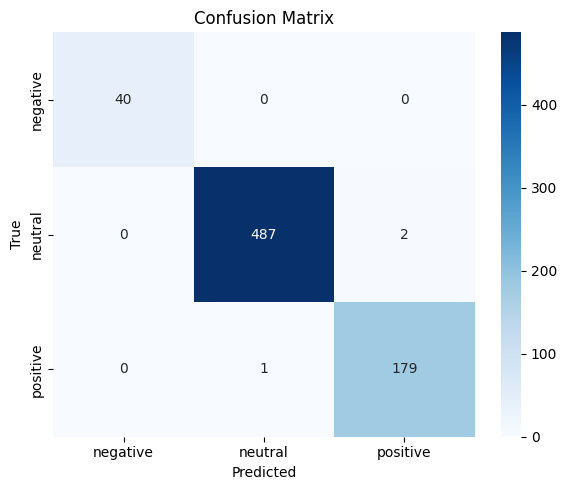

In [6]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

In [8]:
print(report)

              precision    recall  f1-score   support

    negative     1.0000    1.0000    1.0000        40
     neutral     0.9980    0.9959    0.9969       489
    positive     0.9890    0.9944    0.9917       180

    accuracy                         0.9958       709
   macro avg     0.9956    0.9968    0.9962       709
weighted avg     0.9958    0.9958    0.9958       709



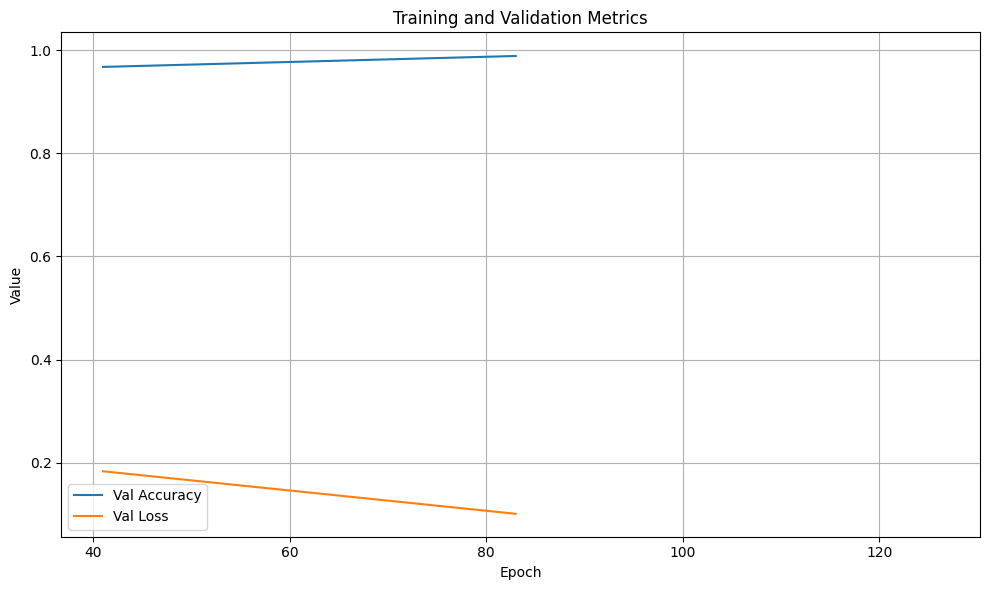

In [9]:
# Convert training history to DataFrame
# Plot all in one figure

epochs_list = [1, 2, 3, 4, 5, 6, 7]

train_history = history_df[history_df["epoch"].isin(epochs_list)]
# Only drop index if epoch==5 exists
epoch5_idx = train_history[train_history["epoch"] == 5].index
if len(epoch5_idx) > 0:
	train_history = train_history.drop(epoch5_idx[0]).reset_index(drop=True)

plt.figure(figsize=(10, 6))

# Accuracy
#plt.plot(train_history['eval_f1'], label='Val F1 Score')
plt.plot(train_history['eval_accuracy'], label='Val Accuracy')

# Loss
#plt.plot(history_df['loss'], label='Train Loss')
plt.plot(train_history['eval_loss'], label='Val Loss')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()